## Phase 2: Behavioral-Mechanistic Linkage Analysis

### Overview
Phase 1 revealed that deeper transformer layers develop "specialist" features that activate selectively for specific text categories. But what are these specialists actually detecting — the underlying **semantic meaning** or merely **surface-level syntactic patterns**?

This phase tests whether semantically equivalent content presented in different surface forms (symbolic notation vs. verbal description vs. prose explanation) activates the same or different features.

### Objectives
1. Test whether the syntactic (rather than semantic) nature of specialist features has measurable consequences for model behavior
2. Compare specialist feature activation across semantically equivalent inputs that vary in surface form
3. Investigate how the model represents semantically equivalent expressions internally
4. Determine whether model accuracy correlates with specialist feature activation strength
5. Validate Phase 1 findings through behavioral experiments

### What We'll Learn
* Whether specialist features' surface-level pattern detection has downstream behavioral consequences
* How strongly surface form (symbolic vs. verbal vs. prose) affects internal representations
* Whether cosine similarity clusters by surface form or by underlying concept
* The relationship between specialist activation and model performance on mathematical completions
* Whether "understanding" in GPT-2 Small is syntax-dependent or concept-independent

### Hypotheses

**H1 (Specialist Activation):** Specialist features will show significantly higher activation for symbolic forms than verbal/prose forms of the same mathematical expression.
- *Example:* The math specialist activates strongly on `x^2 + 2x + 1` but weakly on "x squared plus two x plus one"
- *Implication if supported:* Specialists detect syntactic patterns (symbols, operators) not semantic content

**H2 (Feature Divergence):** Different surface forms of the same concept will activate largely distinct feature populations, with natural language forms (verbal/prose) sharing more overlap with each other than with symbolic notation.
- *Example:* The top-20 features for symbolic math have <50% overlap with top-20 features for verbal math
- *Implication if supported:* GPT-2's representations are organized by surface form, not underlying meaning

**H3 (Representational Clustering):** Activation vectors will cluster by surface form rather than by concept — "2+2" will be more similar to "5*3" (same form, different concept) than to "two plus two" (same concept, different form).
- *Implication if supported:* Internal representations prioritize syntax over semantics

**H4 (Behavioral Correlation):** Model accuracy on mathematical completions will correlate with specialist activation strength and vary by surface form.
- *Implication if supported:* The syntactic nature of specialist features has downstream behavioral consequences

### Approach
1. **Baseline Verification (Cells 2-14):** Replicate Phase 1 specialist identification using identical methodology ✅
2. **Matched Pairs Dataset (Cell 4):** Create semantically equivalent expressions in symbolic, verbal, and prose forms ✅
3. **H1 Testing (Cell 15):** Compare specialist feature activation across forms ✅
4. **H2 Testing (Cell 16):** Analyze feature population overlap between forms ✅
5. **H3 Testing (Cell 17, planned):** Compute cosine similarity matrices
6. **H4 Testing (Cell 18, planned):** Behavioral accuracy experiments

### Success Criteria:
- **Strong positive:** All three hypotheses supported—demonstrates that interpretability findings (specialists detect syntax) have direct behavioral implications (performance depends on surface form)
- **Partial finding:** H1 supported but H2 or H3 inconclusive—confirms Phase 1 findings, suggests conceptual understanding may exist elsewhere
- **Null finding:** No activation or accuracy differences by form—challenges Phase 1 interpretation
- **Unexpected finding:** High similarity despite activation differences—motivates circuit-level investigation

### Available SAEs for Comparison
Building on Phase 0a infrastructure:
* Layer 8 Residual Stream (`8-res-jb`) - Math specialist #22917
* Layer 10 Residual Stream (`10-res-jb`) - Python specialist #15983
* Layer 11 Residual Stream (`11-res-jb`) - Conversational specialist #8955, complete specialization baseline


### Expected Outcomes
* **Quantitative:** Specialist activation values, cosine similarity matrices, accuracy rates by form
* **Visualizations:** Activation bar charts, similarity heatmaps, accuracy comparisons, activation-accuracy scatter plots
* **Narrative:** Assessment of each hypothesis with implications for interpretability research


### Prerequisites
* Completed Phase 1 (specialist features identified, padding masking implemented)
* Phase 1 specialist feature IDs: Math #22917, Python #15983, Conversational #8955
* `extract_features()` function with proper attention masking
* Cached SAEs for layers 8, 10, 11

In [1]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================

import html
from IPython.display import display, Markdown
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

# TransformerLens and SAELens
from transformer_lens import HookedTransformer
from sae_lens import SAE

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
Device: cpu


In [2]:
# ============================================================================
# CELL 3: Check SAE Cache Status
# ============================================================================

print("🔍 Checking SAE Cache Status")
print("=" * 70)

# SAEs can be cached in two locations:
# 1. Direct SAELens cache: ~/.cache/sae_lens/
# 2. HuggingFace hub cache: ~/.cache/huggingface/hub/

sae_lens_cache = Path.home() / ".cache" / "sae_lens"
hf_cache = Path.home() / ".cache" / "huggingface" / "hub"

required_saes = {
    "6-res-jb": "blocks.6.hook_resid_pre",
    "8-res-jb": "blocks.8.hook_resid_pre", 
    "10-res-jb": "blocks.10.hook_resid_pre",
    "11-res-jb": "blocks.11.hook_resid_pre"
    
}

def check_sae_cached(sae_path):
    """Check if SAE is cached in either location"""
    # Check direct cache
    direct_path = sae_lens_cache / sae_path
    if direct_path.exists() and (direct_path / "sae_weights.safetensors").exists():
        return True, direct_path
    
    # Check HuggingFace cache
    if hf_cache.exists():
        for root, dirs, files in os.walk(hf_cache):
            if sae_path in root and "sae_weights.safetensors" in files:
                return True, Path(root)
    
    return False, None

all_cached = True
for sae_name, sae_path in required_saes.items():
    is_cached, cache_path = check_sae_cached(sae_path)
    if is_cached:
        print(f"✅ {sae_name}: Cached at {cache_path}")
    else:
        print(f"❌ {sae_name}: Not cached")
        all_cached = False

print("\n" + "=" * 70)

if all_cached:
    print("\n✅ All SAEs are cached and ready to load!")
    print("💡 Proceed to the next cell to load the SAEs")
else:
    print("\n⚠️  Some SAEs need to be downloaded")
    print("\n📥 Run this in terminal to download missing SAEs:")
    print("python3 -c \"from sae_lens import SAE; SAE.from_pretrained('gpt2-small-res-jb', 'blocks.X.hook_resid_pre', 'cpu')\"")

print("=" * 70)

🔍 Checking SAE Cache Status
✅ 6-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.6.hook_resid_pre
✅ 8-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.8.hook_resid_pre
✅ 10-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.10.hook_resid_pre
✅ 11-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.11.hook_resid_pre


✅ All SAEs are cached and ready to load!
💡 Proceed to the next cell to load the SAEs


In [3]:
# ============================================================================
# CELL 4: Load LLM & All SAEs for Comparison
# ============================================================================

print("🔧 Loading GPT-2 and multiple SAEs...")
print("=" * 70)

# Load model
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device="cpu"
)
print(f"✅ Model loaded: {model.cfg.model_name}")
print()

# SAE cache location (all SAEs are here now)
sae_cache_base = Path.home() / ".cache" / "sae_lens"

# SAE Configuration
available_saes = {
    "6-res-jb": {
        "description": "Layer 6 Residual Stream",
        "hook_point": "blocks.6.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "8-res-jb": {
        "description": "Layer 8 Residual Stream",
        "hook_point": "blocks.8.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "10-res-jb": {
        "description": "Layer 10 Residual Stream",
        "hook_point": "blocks.10.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "11-res-jb": {
        "description": "Layer 11 Residual Stream (Final Layer)",
        "hook_point": "blocks.11.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    }
}

# Load SAEs from disk
loaded_saes = {}

print("Loading SAEs from cache...")
for sae_name, sae_config in available_saes.items():
    print(f"\n📦 Loading {sae_name}: {sae_config['description']}")
    
    sae_path = sae_cache_base / sae_config['hook_point']
    
    if not sae_path.exists():
        print(f"   ❌ Not found at: {sae_path}")
        continue
    
    try:
        # Load directly from disk (no download, no progress bar issues)
        sae = SAE.load_from_disk(str(sae_path))
        
        loaded_saes[sae_name] = {
            "sae": sae,
            "config": sae_config
        }
        print(f"   ✅ Loaded successfully")
        print(f"   📊 Dimensions: {sae_config['d_in']} → {sae_config['d_sae']}")
        print(f"   🎯 Hook point: {sae_config['hook_point']}")
        
    except Exception as e:
        print(f"   ❌ Failed to load: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "=" * 70)
print(f"✅ Successfully loaded {len(loaded_saes)}/{len(available_saes)} SAEs")
if loaded_saes:
    print(f"📋 Available SAEs: {list(loaded_saes.keys())}")
    print("\n🎯 Ready for Phase 2 comparison analysis!")
else:
    print("⚠️  No SAEs loaded successfully.")

print("=" * 70)

🔧 Loading GPT-2 and multiple SAEs...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
✅ Model loaded: gpt2

Loading SAEs from cache...

📦 Loading 6-res-jb: Layer 6 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.6.hook_resid_pre

📦 Loading 8-res-jb: Layer 8 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.8.hook_resid_pre

📦 Loading 10-res-jb: Layer 10 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.10.hook_resid_pre

📦 Loading 11-res-jb: Layer 11 Residual Stream (Final Layer)
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.11.hook_resid_pre

✅ Successfully loaded 4/4 SAEs
📋 Available SAEs: ['6-res-jb', '8-res-jb', '10-res-jb', '11-res-jb']

🎯 Ready for Phase 2 comparison analysis!


In [4]:
# =============================================================================
# Cell 5: BASELINE CATEGORY TEXTS (For Specialist Verification)
# =============================================================================
# Smaller set of original category texts used in Phase 1 to verify specialist features
# still activate as expected before running matched pairs analysis

print("\n📚 Loading Baseline Categories Dataset")
print("=" * 70)


baseline_categories = {
    "Python": [
        "def factorial(n):\n    return 1 if n == 0 else n * factorial(n-1)",
        "import torch\nimport numpy as np\nfrom transformers import AutoModel",
        "class NeuralNetwork(nn.Module):\n    def __init__(self):",
        "for i in range(len(data)):\n    result.append(data[i] ** 2)",
        "try:\n    x = int(input())\nexcept ValueError:\n    print('Error')",
        "lambda x: x ** 2 + 3 * x - 5",
        "if __name__ == '__main__':\n    main()",
        "return [x for x in lst if x > 0]",
        "print(f'Result: {sum(values) / len(values):.2f}')",
        "pip install transformers torch numpy pandas",
    ],
    "URLs": [
        "https://www.github.com/anthropics/claude",
        "Visit our website at http://example.com/products",
        "<html><body><h1>Welcome</h1></body></html>",
        "<div class='container'><p>Content here</p></div>",
        "GET /api/v1/users HTTP/1.1",
        "mailto:support@example.com",
        "www.stackoverflow.com/questions/12345",
        "ftp://files.example.org/downloads/",
        "Click here: https://bit.ly/abc123",
        "Check out reddit.com/r/machinelearning",
    ],
    "Math": [
        "f(x) = x^2 + 2x + 1",
        "∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C",
        "lim(x→0) sin(x)/x = 1",
        "∑(i=1 to n) i = n(n+1)/2",
        "√(a^2 + b^2) = c",
        "P(A|B) = P(B|A)P(A) / P(B)",
        "E = mc^2",
        "∇f(x,y) = (∂f/∂x, ∂f/∂y)",
        "det([[a,b],[c,d]]) = ad - bc",
        "sin^2(θ) + cos^2(θ) = 1",
    ],
    "Non-English": [
        "Bonjour, comment allez-vous aujourd'hui?",
        "你好，今天天气怎么样？",
        "Hola, ¿cómo estás?",
        "Guten Tag, wie geht es Ihnen?",
        "Здравствуйте, как дела?",
        "こんにちは、元気ですか？",
        "مرحبا، كيف حالك؟",
        "안녕하세요, 잘 지내셨어요?",
        "Ciao, come stai?",
        "Olá, como você está?",
    ],
    "Social": [
        "omg that's so funny 😂😂😂",
        "can't wait for the weekend!! 🎉🎊",
        "just got coffee ☕ feeling good ✨",
        "bruh why is this happening 💀",
        "yaaaas queen!!! 👑💅✨",
        "ngl this is pretty cool 🔥",
        "lmaooo i'm dying 😭😭",
        "tbh idk what to do 🤷‍♀️",
        "mood af rn 💯",
        "this slaps fr fr 🎵🔥",
    ],
    "Formal": [
        "The phenomenon was observed under controlled laboratory conditions.",
        "In accordance with the aforementioned regulations, we hereby submit this proposal.",
        "The hypothesis was tested using a double-blind randomized controlled trial.",
        "Pursuant to Article 12, Section 3 of the aforementioned statute.",
        "The results indicate a statistically significant correlation (p < 0.05).",
        "This paper examines the theoretical frameworks underlying modern economics.",
        "The defendant pleaded not guilty to all charges in the indictment.",
        "We acknowledge the contributions of all co-authors and funding agencies.",
        "The experimental methodology followed established protocols.",
        "In conclusion, further research is warranted to investigate this phenomenon.",
    ],
    "Conversational": [
        "Hey, what's up? Want to grab lunch later?",
        "I think the meeting went pretty well today.",
        "The weather is nice, maybe we should go for a walk.",
        "Did you see that movie everyone's talking about?",
        "I'm planning a trip to Japan next summer.",
        "That restaurant has the best pizza in town.",
        "My cat keeps knocking things off the table.",
        "The traffic was terrible this morning.",
        "I need to finish this project by Friday.",
        "Let's catch up over coffee sometime.",
    ]
}


# Flatten baseline categories
baseline_texts = []
baseline_labels = []
for category, text_list in baseline_categories.items():
    for text in text_list:
        baseline_texts.append(text)
        baseline_labels.append(category)


# Indicate successful loading
print(f"\n📋 BASELINE VERIFICATION DATASET:")
print(f"   Categories: {list(baseline_categories.keys())}")
print(f"   Total texts: {len(baseline_texts)}")



📚 Loading Baseline Categories Dataset

📋 BASELINE VERIFICATION DATASET:
   Categories: ['Python', 'URLs', 'Math', 'Non-English', 'Social', 'Formal', 'Conversational']
   Total texts: 70


In [5]:
# ============================================================================
# CELL 6: Load Matched Pairs Dataset for Behavioral-Mechanistic Analysis
# ============================================================================

print("\n📚 Loading Matched Pairs Dataset")
print("=" * 70)

# =============================================================================
# MATCHED PAIRS (Primary Dataset for Phase 2)
# =============================================================================
# Each pair contains the same concept in multiple surface forms.
# This allows testing whether specialist features respond to syntax/form
# rather than semantic content.

# -----------------------------------------------------------------------------
# SIMPLE MATH PAIRS (33 examples, 3 forms each)
# -----------------------------------------------------------------------------
math_pairs_simple = [
    # Basic addition (7)
    {"symbolic": "2+2", "verbal": "two plus two", "prose": "the sum of two and two", "expected": "4", "category": "addition"},
    {"symbolic": "4+5", "verbal": "four plus five", "prose": "the sum of four and five", "expected": "9", "category": "addition"},
    {"symbolic": "1+1", "verbal": "one plus one", "prose": "the sum of one and one", "expected": "2", "category": "addition"},
    {"symbolic": "3+6", "verbal": "three plus six", "prose": "the sum of three and six", "expected": "9", "category": "addition"},
    {"symbolic": "7+2", "verbal": "seven plus two", "prose": "the sum of seven and two", "expected": "9", "category": "addition"},
    {"symbolic": "5+4", "verbal": "five plus four", "prose": "the sum of five and four", "expected": "9", "category": "addition"},
    {"symbolic": "8+1", "verbal": "eight plus one", "prose": "the sum of eight and one", "expected": "9", "category": "addition"},
    
    # Basic subtraction (7)
    {"symbolic": "8-3", "verbal": "eight minus three", "prose": "three less than eight", "expected": "5", "category": "subtraction"},
    {"symbolic": "7-4", "verbal": "seven minus four", "prose": "four less than seven", "expected": "3", "category": "subtraction"},
    {"symbolic": "9-5", "verbal": "nine minus five", "prose": "five less than nine", "expected": "4", "category": "subtraction"},
    {"symbolic": "6-2", "verbal": "six minus two", "prose": "two less than six", "expected": "4", "category": "subtraction"},
    {"symbolic": "5-1", "verbal": "five minus one", "prose": "one less than five", "expected": "4", "category": "subtraction"},
    {"symbolic": "9-3", "verbal": "nine minus three", "prose": "three less than nine", "expected": "6", "category": "subtraction"},
    {"symbolic": "7-2", "verbal": "seven minus two", "prose": "two less than seven", "expected": "5", "category": "subtraction"},
    
    # Basic multiplication (7)
    {"symbolic": "5*3", "verbal": "five times three", "prose": "five multiplied by three", "expected": "15", "category": "multiplication"},
    {"symbolic": "6*2", "verbal": "six times two", "prose": "six multiplied by two", "expected": "12", "category": "multiplication"},
    {"symbolic": "3*4", "verbal": "three times four", "prose": "three multiplied by four", "expected": "12", "category": "multiplication"},
    {"symbolic": "2*7", "verbal": "two times seven", "prose": "two multiplied by seven", "expected": "14", "category": "multiplication"},
    {"symbolic": "4*4", "verbal": "four times four", "prose": "four multiplied by four", "expected": "16", "category": "multiplication"},
    {"symbolic": "3*3", "verbal": "three times three", "prose": "three multiplied by three", "expected": "9", "category": "multiplication"},
    {"symbolic": "2*8", "verbal": "two times eight", "prose": "two multiplied by eight", "expected": "16", "category": "multiplication"},
    
    # Basic division (7)
    {"symbolic": "10/2", "verbal": "ten divided by two", "prose": "half of ten", "expected": "5", "category": "division"},
    {"symbolic": "9/3", "verbal": "nine divided by three", "prose": "a third of nine", "expected": "3", "category": "division"},
    {"symbolic": "8/4", "verbal": "eight divided by four", "prose": "a quarter of eight", "expected": "2", "category": "division"},
    {"symbolic": "6/2", "verbal": "six divided by two", "prose": "half of six", "expected": "3", "category": "division"},
    {"symbolic": "12/4", "verbal": "twelve divided by four", "prose": "a quarter of twelve", "expected": "3", "category": "division"},
    {"symbolic": "15/3", "verbal": "fifteen divided by three", "prose": "a third of fifteen", "expected": "5", "category": "division"},
    {"symbolic": "8/2", "verbal": "eight divided by two", "prose": "half of eight", "expected": "4", "category": "division"},
    
    # Exponents (5)
    {"symbolic": "3^2", "verbal": "three squared", "prose": "three to the power of two", "expected": "9", "category": "exponents"},
    {"symbolic": "2^3", "verbal": "two cubed", "prose": "two to the power of three", "expected": "8", "category": "exponents"},
    {"symbolic": "4^2", "verbal": "four squared", "prose": "four to the power of two", "expected": "16", "category": "exponents"},
    {"symbolic": "5^2", "verbal": "five squared", "prose": "five to the power of two", "expected": "25", "category": "exponents"},
    {"symbolic": "2^4", "verbal": "two to the fourth", "prose": "two to the power of four", "expected": "16", "category": "exponents"},
]


# -----------------------------------------------------------------------------
# COMPLEX MATH PAIRS (33 examples, 3 forms each - 3 per category)
# -----------------------------------------------------------------------------
math_pairs_complex = [
    # Quadratic expressions (3)
    {"symbolic": "x^2 + 2x + 1", "verbal": "x squared plus two x plus one", "prose": "the square of x added to twice x and one", "expected": "(x+1)^2", "category": "Quadratic expressions"},
    {"symbolic": "x^2 - 9", "verbal": "x squared minus nine", "prose": "the square of x with nine subtracted", "expected": "(x+3)(x-3)", "category": "Quadratic expressions"},
    {"symbolic": "x^2 - 5x + 6", "verbal": "x squared minus five x plus six", "prose": "the square of x minus five times x plus six", "expected": "(x-2)(x-3)", "category": "Quadratic expressions"},
    
    # Pythagorean theorem variants (3)
    {"symbolic": "a^2 + b^2 = c^2", "verbal": "a squared plus b squared equals c squared", "prose": "the sum of the squares of a and b equals the square of c", "expected": "Pythagorean theorem", "category": "Pythagorean theorem variants"},
    {"symbolic": "√(a^2 + b^2)", "verbal": "the square root of a squared plus b squared", "prose": "the square root of the sum of a squared and b squared", "expected": "c (hypotenuse)", "category": "Pythagorean theorem variants"},
    {"symbolic": "c = √(3^2 + 4^2) = 5", "verbal": "c equals the square root of three squared plus four squared equals five", "prose": "c equals the square root of nine plus sixteen which equals five", "expected": "3-4-5 triangle", "category": "Pythagorean theorem variants"},
    
    # Famous equations (3)
    {"symbolic": "E = mc^2", "verbal": "E equals m c squared", "prose": "energy equals mass times the speed of light squared", "expected": "mass-energy equivalence", "category": "Famous equations"},
    {"symbolic": "F = ma", "verbal": "F equals m a", "prose": "force equals mass times acceleration", "expected": "Newton's second law", "category": "Famous equations"},
    {"symbolic": "PV = nRT", "verbal": "P V equals n R T", "prose": "pressure times volume equals the number of moles times the gas constant times temperature", "expected": "ideal gas law", "category": "Famous equations"},
    
    # Trigonometric identities (3)
    {"symbolic": "sin^2(θ) + cos^2(θ) = 1", "verbal": "sine squared theta plus cosine squared theta equals one", "prose": "the square of the sine of theta plus the square of the cosine of theta equals one", "expected": "Pythagorean identity", "category": "Trigonometric identities"},
    {"symbolic": "sin(2θ) = 2sin(θ)cos(θ)", "verbal": "sine of two theta equals two sine theta cosine theta", "prose": "the sine of twice theta equals twice the product of sine theta and cosine theta", "expected": "double angle formula", "category": "Trigonometric identities"},
    {"symbolic": "tan(θ) = sin(θ)/cos(θ)", "verbal": "tangent of theta equals sine of theta over cosine of theta", "prose": "the tangent of theta equals the sine of theta divided by the cosine of theta", "expected": "tangent definition", "category": "Trigonometric identities"},
    
    # Exponential/logarithmic (3)
    {"symbolic": "e^(iπ) + 1 = 0", "verbal": "e to the i pi plus one equals zero", "prose": "e raised to the power of i times pi plus one equals zero", "expected": "Euler's identity", "category": "Exponential/logarithmic"},
    {"symbolic": "ln(e^x) = x", "verbal": "natural log of e to the x equals x", "prose": "the natural logarithm of e raised to x equals x", "expected": "log-exp inverse", "category": "Exponential/logarithmic"},
    {"symbolic": "log_a(xy) = log_a(x) + log_a(y)", "verbal": "log base a of x y equals log base a of x plus log base a of y", "prose": "the logarithm base a of the product of x and y equals the sum of the logarithms base a of x and y", "expected": "log product rule", "category": "Exponential/logarithmic"},
    
    # Calculus - derivatives (3)
    {"symbolic": "d/dx(x^2) = 2x", "verbal": "the derivative of x squared equals two x", "prose": "the derivative with respect to x of x squared is two times x", "expected": "power rule", "category": "Calculus - derivatives"},
    {"symbolic": "d/dx(sin(x)) = cos(x)", "verbal": "the derivative of sine x equals cosine x", "prose": "the derivative with respect to x of sine of x is cosine of x", "expected": "trig derivative", "category": "Calculus - derivatives"},
    {"symbolic": "d/dx(e^x) = e^x", "verbal": "the derivative of e to the x equals e to the x", "prose": "the derivative with respect to x of e raised to x is e raised to x", "expected": "exponential derivative", "category": "Calculus - derivatives"},
    
    # Calculus - integrals (3)
    {"symbolic": "∫x^2 dx = x^3/3 + C", "verbal": "the integral of x squared dx equals x cubed over three plus C", "prose": "the integral of x squared with respect to x is x cubed divided by three plus a constant", "expected": "power rule integral", "category": "Calculus - integrals"},
    {"symbolic": "∫sin(x)dx = -cos(x) + C", "verbal": "the integral of sine x dx equals negative cosine x plus C", "prose": "the integral of sine of x with respect to x is negative cosine of x plus a constant", "expected": "trig integral", "category": "Calculus - integrals"},
    {"symbolic": "∫e^x dx = e^x + C", "verbal": "the integral of e to the x dx equals e to the x plus C", "prose": "the integral of e raised to x with respect to x is e raised to x plus a constant", "expected": "exponential integral", "category": "Calculus - integrals"},
    
    # Summation (3)
    {"symbolic": "∑(i=1 to n) i = n(n+1)/2", "verbal": "the sum from i equals one to n of i equals n times n plus one over two", "prose": "the sum of all integers from one to n equals n times n plus one divided by two", "expected": "arithmetic series", "category": "Summation"},
    {"symbolic": "∑(i=1 to n) i^2 = n(n+1)(2n+1)/6", "verbal": "the sum from i equals one to n of i squared equals n times n plus one times two n plus one over six", "prose": "the sum of the squares of all integers from one to n equals n times n plus one times two n plus one divided by six", "expected": "sum of squares", "category": "Summation"},
    {"symbolic": "∑(i=0 to n) r^i = (1-r^(n+1))/(1-r)", "verbal": "the sum from i equals zero to n of r to the i equals one minus r to the n plus one over one minus r", "prose": "the sum of r raised to the i from zero to n equals one minus r raised to n plus one divided by one minus r", "expected": "geometric series", "category": "Summation"},
    
    # Limits (3)
    {"symbolic": "lim(x→0) sin(x)/x = 1", "verbal": "the limit as x approaches zero of sine x over x equals one", "prose": "the limit of sine of x divided by x as x approaches zero is one", "expected": "fundamental trig limit", "category": "Limits"},
    {"symbolic": "lim(x→∞) (1 + 1/x)^x = e", "verbal": "the limit as x approaches infinity of one plus one over x to the x equals e", "prose": "the limit of one plus one divided by x raised to the power x as x approaches infinity is e", "expected": "definition of e", "category": "Limits"},
    {"symbolic": "lim(x→0) (e^x - 1)/x = 1", "verbal": "the limit as x approaches zero of e to the x minus one over x equals one", "prose": "the limit of e raised to x minus one divided by x as x approaches zero is one", "expected": "exponential limit", "category": "Limits"},
    
    # Quadratic formula (3)
    {"symbolic": "x = (-b ± √(b^2-4ac))/2a", "verbal": "x equals negative b plus or minus the square root of b squared minus four a c all over two a", "prose": "x equals the negation of b plus or minus the square root of b squared minus four times a times c all divided by twice a", "expected": "quadratic formula", "category": "Quadratic formula"},
    {"symbolic": "b^2 - 4ac", "verbal": "b squared minus four a c", "prose": "the square of b minus four times a times c", "expected": "discriminant", "category": "Quadratic formula"},
    {"symbolic": "x = -b/2a", "verbal": "x equals negative b over two a", "prose": "x equals the negation of b divided by twice a", "expected": "vertex x-coordinate", "category": "Quadratic formula"},
    
    # Matrix/determinant (3)
    {"symbolic": "det(A) = ad - bc", "verbal": "determinant of A equals a d minus b c", "prose": "the determinant of matrix A is a times d minus b times c", "expected": "2x2 determinant", "category": "Matrix/determinant"},
    {"symbolic": "A^(-1) = (1/det(A)) * adj(A)", "verbal": "A inverse equals one over the determinant of A times the adjugate of A", "prose": "the inverse of matrix A equals one divided by the determinant of A multiplied by the adjugate of A", "expected": "matrix inverse formula", "category": "Matrix/determinant"},
    {"symbolic": "det(AB) = det(A) * det(B)", "verbal": "determinant of A B equals determinant of A times determinant of B", "prose": "the determinant of the product of A and B equals the product of their determinants", "expected": "determinant product rule", "category": "Matrix/determinant"},
]


# -----------------------------------------------------------------------------
# PYTHON PAIRS (35 examples, 2 forms each)
# -----------------------------------------------------------------------------
python_pairs = [
    # Function definitions (5)
    {"code": "def add(x, y): return x + y", "pseudo": "define function add that takes x and y and returns x plus y", "description": "function definition with return"},
    {"code": "def greet(name): print(f'Hello {name}')", "pseudo": "define function greet that takes name and prints hello followed by the name", "description": "function with print"},
    {"code": "def square(n): return n * n", "pseudo": "define function square that takes n and returns n times n", "description": "simple math function"},
    {"code": "def is_even(x): return x % 2 == 0", "pseudo": "define function is even that takes x and returns true if x divided by two has no remainder", "description": "boolean return function"},
    {"code": "def get_max(a, b): return a if a > b else b", "pseudo": "define function get max that takes a and b and returns a if a is greater than b otherwise returns b", "description": "conditional return function"},
    
    # Loops (5)
    {"code": "for i in range(10):", "pseudo": "loop through numbers zero to nine", "description": "for loop with range"},
    {"code": "for item in my_list:", "pseudo": "loop through each item in my list", "description": "for loop over list"},
    {"code": "while x > 0:", "pseudo": "while x is greater than zero", "description": "while loop condition"},
    {"code": "for i, val in enumerate(data):", "pseudo": "loop through data with both index and value", "description": "enumerate loop"},
    {"code": "for key, value in dict.items():", "pseudo": "loop through each key and value pair in the dictionary", "description": "dictionary iteration"},
    
    # Conditionals (5)
    {"code": "if x > 0: return True", "pseudo": "if x is greater than zero then return true", "description": "conditional return"},
    {"code": "if x > 0 and y < 10:", "pseudo": "if x is greater than zero and y is less than ten", "description": "compound conditional"},
    {"code": "if x in my_list:", "pseudo": "if x is contained in my list", "description": "membership check"},
    {"code": "if not found:", "pseudo": "if found is false", "description": "negation conditional"},
    {"code": "result = a if condition else b", "pseudo": "set result to a if condition is true otherwise set it to b", "description": "ternary expression"},
    
    # List operations (5)
    {"code": "len(my_list)", "pseudo": "the length of my list", "description": "length function"},
    {"code": "my_list.append(item)", "pseudo": "add item to the end of my list", "description": "list append"},
    {"code": "my_list.pop()", "pseudo": "remove and return the last item from my list", "description": "list pop"},
    {"code": "sorted(my_list)", "pseudo": "return a sorted copy of my list", "description": "list sorting"},
    {"code": "my_list[::-1]", "pseudo": "reverse my list", "description": "list reversal"},
    
    # Variable assignments (5)
    {"code": "x = y + z", "pseudo": "set x equal to y plus z", "description": "variable assignment"},
    {"code": "x, y = y, x", "pseudo": "swap the values of x and y", "description": "variable swap"},
    {"code": "count += 1", "pseudo": "increase count by one", "description": "increment"},
    {"code": "total = sum(values)", "pseudo": "set total to the sum of all values", "description": "sum assignment"},
    {"code": "name = input('Enter name: ')", "pseudo": "ask the user to enter their name and store it in name", "description": "user input"},
    
    # List comprehensions (5)
    {"code": "[x for x in lst if x > 0]", "pseudo": "create a list of all x from lst where x is greater than zero", "description": "filtered list comprehension"},
    {"code": "[x * 2 for x in range(5)]", "pseudo": "create a list of x times two for each x from zero to four", "description": "mapped list comprehension"},
    {"code": "[x.upper() for x in words]", "pseudo": "create a list of each word in uppercase", "description": "string transformation comprehension"},
    {"code": "{x: x**2 for x in range(5)}", "pseudo": "create a dictionary mapping each number to its square for zero to four", "description": "dictionary comprehension"},
    {"code": "[row[0] for row in matrix]", "pseudo": "create a list of the first element from each row in matrix", "description": "column extraction"},
    
    # String operations (5)
    {"code": "text.split(' ')", "pseudo": "split text into a list by spaces", "description": "string split"},
    {"code": "' '.join(words)", "pseudo": "join all words with spaces between them", "description": "string join"},
    {"code": "text.strip()", "pseudo": "remove whitespace from both ends of text", "description": "string strip"},
    {"code": "text.replace('a', 'b')", "pseudo": "replace all occurrences of a with b in text", "description": "string replace"},
    {"code": "f'Hello {name}, you are {age}'", "pseudo": "create a string saying hello to name and stating their age", "description": "f-string formatting"},
]


# -----------------------------------------------------------------------------
# NON-ENGLISH PAIRS (35 examples, 3 forms: Spanish, French, German)
# Tests: Does the Non-English specialist fire regardless of which language?
# -----------------------------------------------------------------------------
non_english_pairs = [
    # Greetings (5)
    {"spanish": "Hola, ¿cómo estás?", "french": "Bonjour, comment ça va?", "german": "Hallo, wie geht es dir?", "english_meaning": "Hello, how are you?"},
    {"spanish": "Buenos días", "french": "Bonjour", "german": "Guten Morgen", "english_meaning": "Good morning"},
    {"spanish": "Buenas noches", "french": "Bonne nuit", "german": "Gute Nacht", "english_meaning": "Good night"},
    {"spanish": "Hasta luego", "french": "À bientôt", "german": "Bis später", "english_meaning": "See you later"},
    {"spanish": "Mucho gusto", "french": "Enchanté", "german": "Freut mich", "english_meaning": "Nice to meet you"},
    
    # Common phrases (5)
    {"spanish": "Por favor", "french": "S'il vous plaît", "german": "Bitte", "english_meaning": "Please"},
    {"spanish": "Gracias", "french": "Merci", "german": "Danke", "english_meaning": "Thank you"},
    {"spanish": "De nada", "french": "De rien", "german": "Bitte schön", "english_meaning": "You're welcome"},
    {"spanish": "Lo siento", "french": "Je suis désolé", "german": "Es tut mir leid", "english_meaning": "I'm sorry"},
    {"spanish": "No entiendo", "french": "Je ne comprends pas", "german": "Ich verstehe nicht", "english_meaning": "I don't understand"},
    
    # Questions (5)
    {"spanish": "¿Dónde está el baño?", "french": "Où sont les toilettes?", "german": "Wo ist die Toilette?", "english_meaning": "Where is the bathroom?"},
    {"spanish": "¿Cuánto cuesta?", "french": "Combien ça coûte?", "german": "Wie viel kostet das?", "english_meaning": "How much does it cost?"},
    {"spanish": "¿Qué hora es?", "french": "Quelle heure est-il?", "german": "Wie spät ist es?", "english_meaning": "What time is it?"},
    {"spanish": "¿Cómo te llamas?", "french": "Comment tu t'appelles?", "german": "Wie heißt du?", "english_meaning": "What's your name?"},
    {"spanish": "¿Hablas inglés?", "french": "Parlez-vous anglais?", "german": "Sprechen Sie Englisch?", "english_meaning": "Do you speak English?"},
    
    # Statements about self (5)
    {"spanish": "Me llamo María", "french": "Je m'appelle Marie", "german": "Ich heiße Maria", "english_meaning": "My name is Maria"},
    {"spanish": "Tengo veinte años", "french": "J'ai vingt ans", "german": "Ich bin zwanzig Jahre alt", "english_meaning": "I am twenty years old"},
    {"spanish": "Soy de España", "french": "Je suis de France", "german": "Ich komme aus Deutschland", "english_meaning": "I am from [country]"},
    {"spanish": "Vivo en Madrid", "french": "J'habite à Paris", "german": "Ich wohne in Berlin", "english_meaning": "I live in [city]"},
    {"spanish": "Trabajo como profesor", "french": "Je travaille comme professeur", "german": "Ich arbeite als Lehrer", "english_meaning": "I work as a teacher"},
    
    # Daily activities (5)
    {"spanish": "Voy al trabajo", "french": "Je vais au travail", "german": "Ich gehe zur Arbeit", "english_meaning": "I'm going to work"},
    {"spanish": "Quiero comer algo", "french": "Je veux manger quelque chose", "german": "Ich möchte etwas essen", "english_meaning": "I want to eat something"},
    {"spanish": "Necesito dormir", "french": "J'ai besoin de dormir", "german": "Ich muss schlafen", "english_meaning": "I need to sleep"},
    {"spanish": "Me gusta leer libros", "french": "J'aime lire des livres", "german": "Ich lese gerne Bücher", "english_meaning": "I like to read books"},
    {"spanish": "Estoy aprendiendo español", "french": "J'apprends le français", "german": "Ich lerne Deutsch", "english_meaning": "I'm learning [language]"},
    
    # Weather and environment (5)
    {"spanish": "Hace buen tiempo hoy", "french": "Il fait beau aujourd'hui", "german": "Das Wetter ist heute schön", "english_meaning": "The weather is nice today"},
    {"spanish": "Está lloviendo", "french": "Il pleut", "german": "Es regnet", "english_meaning": "It's raining"},
    {"spanish": "Hace mucho calor", "french": "Il fait très chaud", "german": "Es ist sehr heiß", "english_meaning": "It's very hot"},
    {"spanish": "El cielo está despejado", "french": "Le ciel est dégagé", "german": "Der Himmel ist klar", "english_meaning": "The sky is clear"},
    {"spanish": "Me encanta la naturaleza", "french": "J'adore la nature", "german": "Ich liebe die Natur", "english_meaning": "I love nature"},
    
    # Opinions and feelings (5)
    {"spanish": "Estoy muy feliz", "french": "Je suis très heureux", "german": "Ich bin sehr glücklich", "english_meaning": "I am very happy"},
    {"spanish": "Esto es interesante", "french": "C'est intéressant", "german": "Das ist interessant", "english_meaning": "This is interesting"},
    {"spanish": "No me gusta esto", "french": "Je n'aime pas ça", "german": "Das gefällt mir nicht", "english_meaning": "I don't like this"},
    {"spanish": "Es muy importante", "french": "C'est très important", "german": "Das ist sehr wichtig", "english_meaning": "It's very important"},
    {"spanish": "Creo que tienes razón", "french": "Je pense que tu as raison", "german": "Ich glaube, du hast recht", "english_meaning": "I think you're right"},
]


# -----------------------------------------------------------------------------
# SOCIAL PAIRS (35 examples, 3 forms: full_social, partial_social, standard)
# Tests: Does the Social specialist fire based on slang/emoji intensity?
# -----------------------------------------------------------------------------
social_pairs = [
    # Excitement/enthusiasm (7)
    {"full_social": "omg that's so funny 😂😂😂", "partial_social": "omg thats so funny", "standard": "That's very funny", "meaning": "expressing amusement"},
    {"full_social": "yaaaas queen!!! 👑💅✨", "partial_social": "yaaas queen", "standard": "I strongly approve", "meaning": "expressing strong approval"},
    {"full_social": "this slaps fr fr 🔥💯", "partial_social": "this slaps fr fr", "standard": "This is really good", "meaning": "expressing quality"},
    {"full_social": "im literally dying rn 💀😭", "partial_social": "im literally dying rn", "standard": "I find this extremely funny", "meaning": "expressing intense amusement"},
    {"full_social": "lets gooo!!! 🎉🙌", "partial_social": "lets gooo", "standard": "I'm very excited about this", "meaning": "expressing excitement"},
    {"full_social": "no cap this is fire 🔥🔥", "partial_social": "no cap this is fire", "standard": "Honestly, this is excellent", "meaning": "expressing genuine praise"},
    {"full_social": "slay bestie!!! 💖✨👏", "partial_social": "slay bestie", "standard": "Well done, my friend", "meaning": "congratulating a friend"},
    
    # Negative reactions (7)
    {"full_social": "bruh why is this happening 💀", "partial_social": "bruh why is this happening", "standard": "I don't understand why this is happening", "meaning": "expressing confusion"},
    {"full_social": "im so done rn 😤😤", "partial_social": "im so done rn", "standard": "I'm very frustrated right now", "meaning": "expressing frustration"},
    {"full_social": "this aint it chief 😬", "partial_social": "this aint it chief", "standard": "This isn't good", "meaning": "expressing disapproval"},
    {"full_social": "oof thats rough 😢", "partial_social": "oof thats rough", "standard": "That's unfortunate", "meaning": "expressing sympathy"},
    {"full_social": "that's sus ngl 🤨", "partial_social": "thats sus ngl", "standard": "That seems suspicious honestly", "meaning": "expressing suspicion"},
    {"full_social": "L take fr 👎", "partial_social": "L take fr", "standard": "That's a bad opinion", "meaning": "disagreeing with opinion"},
    {"full_social": "cringe af 😬😬", "partial_social": "cringe af", "standard": "That's embarrassing", "meaning": "expressing secondhand embarrassment"},
    
    # Daily updates (7)
    {"full_social": "just got coffee ☕ feeling good ✨", "partial_social": "just got coffee feeling good", "standard": "I just got coffee and I feel good", "meaning": "sharing daily activity"},
    {"full_social": "can't wait for the weekend!! 🎉🎊", "partial_social": "cant wait for the weekend", "standard": "I'm looking forward to the weekend", "meaning": "anticipating weekend"},
    {"full_social": "mood af rn 💯", "partial_social": "mood af rn", "standard": "I really relate to this right now", "meaning": "expressing relatability"},
    {"full_social": "vibes are immaculate today ✨🌟", "partial_social": "vibes are immaculate today", "standard": "The atmosphere is very pleasant today", "meaning": "describing good mood"},
    {"full_social": "living my best life 💅🏝️", "partial_social": "living my best life", "standard": "I'm enjoying life to the fullest", "meaning": "expressing contentment"},
    {"full_social": "its giving main character energy 💫", "partial_social": "its giving main character energy", "standard": "This makes me feel important", "meaning": "feeling special"},
    {"full_social": "ate and left no crumbs 🍽️✨", "partial_social": "ate and left no crumbs", "standard": "That was done perfectly", "meaning": "expressing perfection"},
    
    # Uncertainty/confusion (7)
    {"full_social": "tbh idk what to do 🤷‍♀️😅", "partial_social": "tbh idk what to do", "standard": "Honestly, I don't know what to do", "meaning": "expressing uncertainty"},
    {"full_social": "ngl this is confusing 😵", "partial_social": "ngl this is confusing", "standard": "I won't lie, this is confusing", "meaning": "admitting confusion"},
    {"full_social": "wait what 👀❓", "partial_social": "wait what", "standard": "I'm surprised, what happened?", "meaning": "seeking clarification"},
    {"full_social": "lowkey dont get it 🤔", "partial_social": "lowkey dont get it", "standard": "I somewhat don't understand", "meaning": "partial confusion"},
    {"full_social": "im confusion 😂😵", "partial_social": "im confusion", "standard": "I'm confused", "meaning": "being confused"},
    {"full_social": "wdym by that 🧐", "partial_social": "wdym by that", "standard": "What do you mean by that?", "meaning": "asking for clarification"},
    {"full_social": "idk tbh could go either way 🤷", "partial_social": "idk tbh could go either way", "standard": "I don't know, it could go either way", "meaning": "expressing indecision"},
    
    # Agreement/support (7)
    {"full_social": "ngl this is pretty cool 🔥", "partial_social": "ngl this is pretty cool", "standard": "I won't lie, this is quite nice", "meaning": "expressing approval"},
    {"full_social": "facts no printer 📠💯", "partial_social": "facts no printer", "standard": "That's absolutely true", "meaning": "strong agreement"},
    {"full_social": "say it louder!! 📢🗣️", "partial_social": "say it louder", "standard": "I strongly agree with that statement", "meaning": "emphatic agreement"},
    {"full_social": "preach!! 🙌🙏", "partial_social": "preach", "standard": "I completely agree", "meaning": "strong support"},
    {"full_social": "real talk 💯💯", "partial_social": "real talk", "standard": "Speaking honestly", "meaning": "emphasizing sincerity"},
    {"full_social": "ong thats so true 🙏", "partial_social": "ong thats so true", "standard": "On God, that's so true", "meaning": "affirming truth"},
    {"full_social": "W take bestie 🏆", "partial_social": "W take bestie", "standard": "That's a great opinion, friend", "meaning": "praising opinion"},
]


# -----------------------------------------------------------------------------
# FORMAL PAIRS (35 examples, 3 forms: highly_formal, moderately_formal, plain)
# Tests: Does the Formal specialist fire based on register/formality level?
# -----------------------------------------------------------------------------
formal_pairs = [
    # Academic/research statements (7)
    {"highly_formal": "The phenomenon was observed under controlled laboratory conditions.", "moderately_formal": "We observed the phenomenon in controlled lab conditions.", "plain": "We saw this happen in the lab.", "topic": "research observation"},
    {"highly_formal": "The hypothesis was tested using a double-blind randomized controlled trial.", "moderately_formal": "We tested the hypothesis with a controlled trial.", "plain": "We ran a test to check our idea.", "topic": "research methodology"},
    {"highly_formal": "The results indicate a statistically significant correlation (p < 0.05).", "moderately_formal": "The results show a significant correlation.", "plain": "The results show a real connection.", "topic": "research findings"},
    {"highly_formal": "This paper examines the theoretical frameworks underlying modern economics.", "moderately_formal": "This paper looks at economic theories.", "plain": "This paper is about economic ideas.", "topic": "paper introduction"},
    {"highly_formal": "In conclusion, further research is warranted to investigate this phenomenon.", "moderately_formal": "In conclusion, more research is needed.", "plain": "We need to study this more.", "topic": "research conclusion"},
    {"highly_formal": "The methodology employed herein adheres to established scientific protocols.", "moderately_formal": "Our methods follow standard scientific practices.", "plain": "We used normal science methods.", "topic": "methodology"},
    {"highly_formal": "The aforementioned findings corroborate previous scholarly investigations.", "moderately_formal": "These findings support earlier research.", "plain": "This matches what others found before.", "topic": "literature comparison"},
    
    # Legal/official statements (7)
    {"highly_formal": "In accordance with the aforementioned regulations, we hereby submit this proposal.", "moderately_formal": "Following the regulations, we submit this proposal.", "plain": "We're sending this proposal as required.", "topic": "official submission"},
    {"highly_formal": "Pursuant to Article 12, Section 3 of the aforementioned statute.", "moderately_formal": "According to Article 12, Section 3 of the law.", "plain": "Based on what the law says.", "topic": "legal reference"},
    {"highly_formal": "The defendant pleaded not guilty to all charges in the indictment.", "moderately_formal": "The defendant denied all the charges.", "plain": "The accused said they didn't do it.", "topic": "legal proceedings"},
    {"highly_formal": "Notwithstanding the provisions set forth herein, exceptions may apply.", "moderately_formal": "Despite these rules, there may be exceptions.", "plain": "These rules might have some exceptions.", "topic": "legal exceptions"},
    {"highly_formal": "The undersigned hereby acknowledges receipt of the aforementioned documentation.", "moderately_formal": "I confirm that I received the documents.", "plain": "I got the papers.", "topic": "acknowledgment"},
    {"highly_formal": "Any breach of the terms stipulated herein shall result in immediate termination.", "moderately_formal": "Breaking these terms will end the agreement.", "plain": "If you break the rules, we'll end this.", "topic": "contract terms"},
    {"highly_formal": "The parties hereto agree to be bound by the provisions contained herein.", "moderately_formal": "Both parties agree to follow these terms.", "plain": "Everyone agrees to these rules.", "topic": "agreement"},
    
    # Business/professional statements (7)
    {"highly_formal": "We acknowledge the contributions of all co-authors and funding agencies.", "moderately_formal": "We thank our co-authors and funders.", "plain": "Thanks to everyone who helped and paid for this.", "topic": "acknowledgments"},
    {"highly_formal": "The quarterly projections demonstrate sustained growth across all sectors.", "moderately_formal": "The quarterly projections show growth in all areas.", "plain": "We're growing in all areas this quarter.", "topic": "business report"},
    {"highly_formal": "We respectfully request your consideration of this matter at your earliest convenience.", "moderately_formal": "Please consider this matter when you can.", "plain": "Please look at this when you get a chance.", "topic": "polite request"},
    {"highly_formal": "The undersigned parties have reached a mutually beneficial agreement.", "moderately_formal": "Both sides have reached a good agreement.", "plain": "We made a deal that works for everyone.", "topic": "agreement"},
    {"highly_formal": "Your continued patronage is greatly appreciated by the management.", "moderately_formal": "We appreciate your continued business.", "plain": "Thanks for being a customer.", "topic": "customer appreciation"},
    {"highly_formal": "It is incumbent upon all stakeholders to adhere to the established protocols.", "moderately_formal": "All stakeholders should follow the protocols.", "plain": "Everyone needs to follow the rules.", "topic": "compliance"},
    {"highly_formal": "The implementation timeline is contingent upon resource allocation.", "moderately_formal": "The timeline depends on available resources.", "plain": "When we do this depends on what we have.", "topic": "planning"},
    
    # Instructions/procedures (7)
    {"highly_formal": "Ensure that all requisite documentation is submitted prior to the deadline.", "moderately_formal": "Make sure to submit all required documents before the deadline.", "plain": "Send in all your papers before the due date.", "topic": "submission instructions"},
    {"highly_formal": "The apparatus should be calibrated in accordance with manufacturer specifications.", "moderately_formal": "Calibrate the equipment according to the manual.", "plain": "Set up the equipment like the instructions say.", "topic": "equipment setup"},
    {"highly_formal": "Failure to comply with the stipulated guidelines may result in disqualification.", "moderately_formal": "Not following the guidelines could lead to disqualification.", "plain": "If you don't follow the rules, you might be out.", "topic": "compliance warning"},
    {"highly_formal": "Participants are advised to familiarize themselves with the procedural requirements.", "moderately_formal": "Participants should learn the procedures.", "plain": "Learn what you need to do.", "topic": "preparation"},
    {"highly_formal": "All personnel must adhere to the established safety protocols at all times.", "moderately_formal": "All staff must follow safety rules.", "plain": "Everyone has to follow safety rules.", "topic": "safety"},
    {"highly_formal": "Inquiries regarding this matter should be directed to the appropriate department.", "moderately_formal": "Questions about this should go to the right department.", "plain": "Ask the right people if you have questions.", "topic": "directing inquiries"},
    {"highly_formal": "The experimental methodology followed established protocols.", "moderately_formal": "The experiment followed standard methods.", "plain": "We did the experiment the normal way.", "topic": "methodology"},
    
    # Descriptions and explanations (7)
    {"highly_formal": "The edifice exhibits characteristics consistent with neo-classical architectural principles.", "moderately_formal": "The building shows neo-classical architecture.", "plain": "The building looks old-fashioned and fancy.", "topic": "architecture"},
    {"highly_formal": "The systemic ramifications of this decision warrant careful deliberation.", "moderately_formal": "The effects of this decision need careful thought.", "plain": "We need to think carefully about what this means.", "topic": "decision impact"},
    {"highly_formal": "The prevalence of this condition has increased substantially over recent decades.", "moderately_formal": "This condition has become much more common recently.", "plain": "A lot more people have this now than before.", "topic": "health trends"},
    {"highly_formal": "The discourse surrounding this issue remains contentious among scholars.", "moderately_formal": "Scholars still disagree about this issue.", "plain": "Experts still argue about this.", "topic": "academic debate"},
    {"highly_formal": "The implementation necessitates a comprehensive restructuring of existing frameworks.", "moderately_formal": "This requires major changes to current systems.", "plain": "We need to change a lot of how things work.", "topic": "organizational change"},
    {"highly_formal": "The efficacy of the intervention was evaluated through longitudinal assessment.", "moderately_formal": "We tested how well the intervention worked over time.", "plain": "We checked if it worked over a long time.", "topic": "evaluation"},
    {"highly_formal": "The aforementioned constraints preclude the possibility of immediate implementation.", "moderately_formal": "These constraints prevent immediate implementation.", "plain": "We can't do this right away because of these problems.", "topic": "constraints"},
]


# -----------------------------------------------------------------------------
# CONVERSATIONAL PAIRS (35 examples, 3 forms: first_person, third_person, neutral)
# Tests: Does the Conversational specialist distinguish perspective/voice?
# -----------------------------------------------------------------------------
conversational_pairs = [
    # Plans and intentions (7)
    {"first_person": "I'm planning a trip to Japan", "third_person": "She is planning a trip to Japan", "neutral": "There are plans for a trip to Japan", "topic": "travel planning"},
    {"first_person": "I want to learn something new", "third_person": "He wants to learn something new", "neutral": "There is a desire to learn something new", "topic": "learning"},
    {"first_person": "I need to finish this project by Friday", "third_person": "They need to finish this project by Friday", "neutral": "The project needs to be finished by Friday", "topic": "work deadline"},
    {"first_person": "I'm thinking about changing careers", "third_person": "She's thinking about changing careers", "neutral": "A career change is being considered", "topic": "career change"},
    {"first_person": "I'm going to start exercising more", "third_person": "He's going to start exercising more", "neutral": "More exercise is planned", "topic": "fitness goals"},
    {"first_person": "I hope to visit my family soon", "third_person": "She hopes to visit her family soon", "neutral": "A family visit is hoped for soon", "topic": "family visit"},
    {"first_person": "I'm saving money for a new car", "third_person": "He's saving money for a new car", "neutral": "Money is being saved for a new car", "topic": "saving money"},
    
    # Opinions and thoughts (7)
    {"first_person": "I think this is important", "third_person": "He thinks this is important", "neutral": "This is considered important", "topic": "importance"},
    {"first_person": "I believe we should try a different approach", "third_person": "She believes they should try a different approach", "neutral": "A different approach is believed to be needed", "topic": "suggestion"},
    {"first_person": "I feel like something is wrong", "third_person": "He feels like something is wrong", "neutral": "Something seems wrong", "topic": "intuition"},
    {"first_person": "I don't think this will work", "third_person": "She doesn't think this will work", "neutral": "This doesn't seem likely to work", "topic": "doubt"},
    {"first_person": "I'm not sure what to do next", "third_person": "They're not sure what to do next", "neutral": "The next step is uncertain", "topic": "uncertainty"},
    {"first_person": "I prefer working from home", "third_person": "He prefers working from home", "neutral": "Working from home is preferred", "topic": "work preference"},
    {"first_person": "I love this kind of weather", "third_person": "She loves this kind of weather", "neutral": "This kind of weather is enjoyable", "topic": "weather preference"},
    
    # States and feelings (7)
    {"first_person": "I'm feeling tired today", "third_person": "She is feeling tired today", "neutral": "There is tiredness today", "topic": "tiredness"},
    {"first_person": "I'm really excited about this opportunity", "third_person": "He's really excited about this opportunity", "neutral": "There is excitement about this opportunity", "topic": "excitement"},
    {"first_person": "I'm worried about the deadline", "third_person": "She's worried about the deadline", "neutral": "There is worry about the deadline", "topic": "worry"},
    {"first_person": "I'm happy with how things turned out", "third_person": "They're happy with how things turned out", "neutral": "There is happiness with how things turned out", "topic": "satisfaction"},
    {"first_person": "I'm frustrated with this situation", "third_person": "He's frustrated with this situation", "neutral": "There is frustration with this situation", "topic": "frustration"},
    {"first_person": "I'm confident we'll succeed", "third_person": "She's confident they'll succeed", "neutral": "There is confidence in success", "topic": "confidence"},
    {"first_person": "I'm nervous about the presentation", "third_person": "He's nervous about the presentation", "neutral": "There is nervousness about the presentation", "topic": "nervousness"},
    
    # Daily activities and observations (7)
    {"first_person": "I just finished reading a great book", "third_person": "She just finished reading a great book", "neutral": "A great book was just finished", "topic": "reading"},
    {"first_person": "I had a productive meeting today", "third_person": "He had a productive meeting today", "neutral": "There was a productive meeting today", "topic": "meetings"},
    {"first_person": "I saw an interesting documentary last night", "third_person": "They saw an interesting documentary last night", "neutral": "An interesting documentary was seen last night", "topic": "entertainment"},
    {"first_person": "I cooked dinner for my friends", "third_person": "She cooked dinner for her friends", "neutral": "Dinner was cooked for friends", "topic": "cooking"},
    {"first_person": "I went for a long walk this morning", "third_person": "He went for a long walk this morning", "neutral": "A long walk was taken this morning", "topic": "exercise"},
    {"first_person": "I met with my team to discuss the project", "third_person": "She met with her team to discuss the project", "neutral": "The team met to discuss the project", "topic": "team meeting"},
    {"first_person": "I received some good news yesterday", "third_person": "He received some good news yesterday", "neutral": "Good news was received yesterday", "topic": "news"},
    
    # Casual observations and small talk (7)
    {"first_person": "I think the meeting went pretty well today", "third_person": "She thinks the meeting went pretty well today", "neutral": "The meeting seems to have gone well today", "topic": "meeting review"},
    {"first_person": "I noticed the weather is nice today", "third_person": "He noticed the weather is nice today", "neutral": "The weather is nice today", "topic": "weather"},
    {"first_person": "I heard there's a new restaurant downtown", "third_person": "She heard there's a new restaurant downtown", "neutral": "There's apparently a new restaurant downtown", "topic": "local news"},
    {"first_person": "I can't believe how fast time flies", "third_person": "He can't believe how fast time flies", "neutral": "Time seems to fly by quickly", "topic": "time passing"},
    {"first_person": "I really enjoyed the concert last weekend", "third_person": "They really enjoyed the concert last weekend", "neutral": "The concert last weekend was enjoyable", "topic": "events"},
    {"first_person": "I find this topic fascinating", "third_person": "She finds this topic fascinating", "neutral": "This topic is fascinating", "topic": "interest"},
    {"first_person": "I appreciate your help with this", "third_person": "He appreciates your help with this", "neutral": "Your help with this is appreciated", "topic": "gratitude"},
]


# =============================================================================
# FLATTEN DATASETS
# =============================================================================

# --- Math Complex ---
math_complex_symbolic = [p["symbolic"] for p in math_pairs_complex]
math_complex_verbal = [p["verbal"] for p in math_pairs_complex]
math_complex_prose = [p["prose"] for p in math_pairs_complex]
math_complex_expected = [p["expected"] for p in math_pairs_complex]

all_math_complex_texts = math_complex_symbolic + math_complex_verbal + math_complex_prose
math_complex_form_labels = (["symbolic"] * len(math_pairs_complex) + 
                            ["verbal"] * len(math_pairs_complex) + 
                            ["prose"] * len(math_pairs_complex))

# --- Math Simple ---
math_simple_symbolic = [p["symbolic"] for p in math_pairs_simple]
math_simple_verbal = [p["verbal"] for p in math_pairs_simple]
math_simple_prose = [p["prose"] for p in math_pairs_simple]
math_simple_expected = [p["expected"] for p in math_pairs_simple]

all_math_simple_texts = math_simple_symbolic + math_simple_verbal + math_simple_prose
math_simple_form_labels = (["symbolic"] * len(math_pairs_simple) + 
                           ["verbal"] * len(math_pairs_simple) + 
                           ["prose"] * len(math_pairs_simple))

# --- Python ---
python_code = [p["code"] for p in python_pairs]
python_pseudo = [p["pseudo"] for p in python_pairs]

all_python_texts = python_code + python_pseudo
python_form_labels = (["code"] * len(python_pairs) + 
                      ["pseudo"] * len(python_pairs))

# --- Non-English ---
non_english_spanish = [p["spanish"] for p in non_english_pairs]
non_english_french = [p["french"] for p in non_english_pairs]
non_english_german = [p["german"] for p in non_english_pairs]

all_non_english_texts = non_english_spanish + non_english_french + non_english_german
non_english_form_labels = (["spanish"] * len(non_english_pairs) + 
                           ["french"] * len(non_english_pairs) + 
                           ["german"] * len(non_english_pairs))

# --- Social ---
social_full = [p["full_social"] for p in social_pairs]
social_partial = [p["partial_social"] for p in social_pairs]
social_standard = [p["standard"] for p in social_pairs]

all_social_texts = social_full + social_partial + social_standard
social_form_labels = (["full_social"] * len(social_pairs) + 
                      ["partial_social"] * len(social_pairs) + 
                      ["standard"] * len(social_pairs))

# --- Formal ---
formal_high = [p["highly_formal"] for p in formal_pairs]
formal_moderate = [p["moderately_formal"] for p in formal_pairs]
formal_plain = [p["plain"] for p in formal_pairs]

all_formal_texts = formal_high + formal_moderate + formal_plain
formal_form_labels = (["highly_formal"] * len(formal_pairs) + 
                      ["moderately_formal"] * len(formal_pairs) + 
                      ["plain"] * len(formal_pairs))

# --- Conversational ---
conv_first = [p["first_person"] for p in conversational_pairs]
conv_third = [p["third_person"] for p in conversational_pairs]
conv_neutral = [p["neutral"] for p in conversational_pairs]

all_conv_texts = conv_first + conv_third + conv_neutral
conv_form_labels = (["first_person"] * len(conversational_pairs) + 
                    ["third_person"] * len(conversational_pairs) +
                    ["neutral"] * len(conversational_pairs))


# =============================================================================
# SUMMARY
# =============================================================================

print(f"\n📊 MATCHED PAIRS DATASETS:")
print(f"\n   MATH:")
print(f"      Complex:        {len(math_pairs_complex)} pairs × 3 forms = {len(all_math_complex_texts)} texts")
print(f"      Simple:         {len(math_pairs_simple)} pairs × 3 forms = {len(all_math_simple_texts)} texts")
print(f"\n   CODE:")
print(f"      Python:         {len(python_pairs)} pairs × 2 forms = {len(all_python_texts)} texts")
print(f"\n   LANGUAGE/STYLE:")
print(f"      Non-English:    {len(non_english_pairs)} pairs × 3 forms = {len(all_non_english_texts)} texts")
print(f"      Social:         {len(social_pairs)} pairs × 3 forms = {len(all_social_texts)} texts")
print(f"      Formal:         {len(formal_pairs)} pairs × 3 forms = {len(all_formal_texts)} texts")
print(f"      Conversational: {len(conversational_pairs)} pairs × 3 forms = {len(all_conv_texts)} texts")

total_pairs = (len(math_pairs_complex) + len(math_pairs_simple) + len(python_pairs) + 
               len(non_english_pairs) + len(social_pairs) + len(formal_pairs) + len(conversational_pairs))
total_texts = (len(all_math_complex_texts) + len(all_math_simple_texts) + len(all_python_texts) +
               len(all_non_english_texts) + len(all_social_texts) + len(all_formal_texts) + len(all_conv_texts))

print(f"\n   TOTAL: {total_pairs} pairs → {total_texts} texts")

print(f"\n🔬 ANALYSIS READY:")
print(f"   • Specialist activation comparison across surface forms")
print(f"   • Feature population divergence by form")
print(f"   • Cosine similarity / representational geometry")
print(f"   • Behavioral accuracy by form (where applicable)")

print("\n" + "=" * 70)

# Preview samples from each dataset
print("\n📝 Sample Math Complex Pairs:")
for i, pair in enumerate(math_pairs_complex[:2]):
    print(f"\n   Pair {i+1}: {pair['expected']}")
    print(f"      Symbolic: {pair['symbolic']}")
    print(f"      Verbal:   {pair['verbal']}")
    print(f"      Prose:    {pair['prose']}")

print("\n📝 Sample Non-English Pairs:")
for i, pair in enumerate(non_english_pairs[:2]):
    print(f"\n   Pair {i+1}: \"{pair['english_meaning']}\"")
    print(f"      Spanish: {pair['spanish']}")
    print(f"      French:  {pair['french']}")
    print(f"      German:  {pair['german']}")

print("\n📝 Sample Social Pairs:")
for i, pair in enumerate(social_pairs[:2]):
    print(f"\n   Pair {i+1}: {pair['meaning']}")
    print(f"      Full social:    {pair['full_social']}")
    print(f"      Partial social: {pair['partial_social']}")
    print(f"      Standard:       {pair['standard']}")

print("\n📝 Sample Formal Pairs:")
for i, pair in enumerate(formal_pairs[:2]):
    print(f"\n   Pair {i+1}: {pair['topic']}")
    print(f"      Highly formal:     {pair['highly_formal']}")
    print(f"      Moderately formal: {pair['moderately_formal']}")
    print(f"      Plain:             {pair['plain']}")

print("\n📝 Sample Conversational Pairs:")
for i, pair in enumerate(conversational_pairs[:2]):
    print(f"\n   Pair {i+1}: {pair['topic']}")
    print(f"      First person:  {pair['first_person']}")
    print(f"      Third person:  {pair['third_person']}")
    print(f"      Neutral:       {pair['neutral']}")

print("\n" + "=" * 70)


📚 Loading Matched Pairs Dataset

📊 MATCHED PAIRS DATASETS:

   MATH:
      Complex:        33 pairs × 3 forms = 99 texts
      Simple:         33 pairs × 3 forms = 99 texts

   CODE:
      Python:         35 pairs × 2 forms = 70 texts

   LANGUAGE/STYLE:
      Non-English:    35 pairs × 3 forms = 105 texts
      Social:         35 pairs × 3 forms = 105 texts
      Formal:         35 pairs × 3 forms = 105 texts
      Conversational: 35 pairs × 3 forms = 105 texts

   TOTAL: 241 pairs → 688 texts

🔬 ANALYSIS READY:
   • Specialist activation comparison across surface forms
   • Feature population divergence by form
   • Cosine similarity / representational geometry
   • Behavioral accuracy by form (where applicable)


📝 Sample Math Complex Pairs:

   Pair 1: (x+1)^2
      Symbolic: x^2 + 2x + 1
      Verbal:   x squared plus two x plus one
      Prose:    the square of x added to twice x and one

   Pair 2: (x+3)(x-3)
      Symbolic: x^2 - 9
      Verbal:   x squared minus nine
      Pr

In [6]:
# ============================================================================
# CELL 7: Define Helper Functions for Analysis and Displaying Results
# ============================================================================

print("\n🔬 Defining Helper Functions for Analysis and Displaying Results")
print("=" * 70)

# =============================================================================
# PART 1: Baseline Verification Functions (Carried over from Phase 1)
# =============================================================================

'''
Note: "features" is a 2D tensor containing feature activations:
    features.shape -> torch.Size([num_texts, num_sae_features])
    features.dtype -> data type (e.g., float32)
    features.device -> where stored (CPU or GPU)
'''

def analyze_strongest(features: torch.Tensor, texts: list) -> dict:
    """Find the feature with highest maximum activation across all texts."""
    max_activations = features.max(dim=0)
    strongest_feature_idx = max_activations.values.argmax().item()
    strongest_max_val = max_activations.values.max().item()
    text_idx = max_activations.indices[strongest_feature_idx].item()
    text = texts[text_idx]
    return {
        'feature_idx': strongest_feature_idx,
        'value': strongest_max_val,
        'text': text
    }


def analyze_frequent(features: torch.Tensor, texts: list) -> dict:
    """Find the most frequently activated feature (activates on most texts)."""
    feature_frequency = (features > 0).sum(dim=0)
    most_frequent_feature_idx = feature_frequency.argmax().item()
    most_frequent_feature_count = feature_frequency.max().item()
    return {
        'feature_idx': most_frequent_feature_idx,
        'value': most_frequent_feature_count,
        'text': None
    }


def analyze_selective(features: torch.Tensor, texts: list, threshold: float = 5.0) -> dict:
    """Find the most selective feature (high activation but rare)."""
    strong_activations = (features > threshold)
    strong_activation_counts = strong_activations.sum(dim=0)
    has_strong_activation = strong_activation_counts > 0
    
    selectivity_counts = strong_activation_counts.clone().float()
    selectivity_counts[~has_strong_activation] = float('inf')
    
    most_selective_idx = selectivity_counts.argmin().item()
    selective_max_val = features[:, most_selective_idx].max().item()
    selective_count = strong_activation_counts[most_selective_idx].item()
    total_active_count = (features[:, most_selective_idx] > 0).sum().item()
    text_idx = features[:, most_selective_idx].argmax().item()
    text = texts[text_idx]
    
    return {
        'feature_idx': most_selective_idx,
        'value': selective_max_val,
        'text': text,
        'selective_count': selective_count,
        'total_active_count': total_active_count
    }


def analyze_specialists(features: torch.Tensor, texts: list, categories: dict, threshold: float = 5.0) -> dict:
    """
    For each category, find the best specialist feature.
    Used for baseline verification with category-structured data.
    """
    results = {}
    
    for cat_name, cat_texts in categories.items():
        indices = [i for i, text in enumerate(texts) if text in cat_texts]
        cat_features = features[indices, :]
        cat_max = cat_features.max(dim=0)
        top_features = cat_max.values.topk(5)
        
        best_specialist_idx = None
        best_score = -1
        best_info = None
        
        for max_val, feat_idx in zip(top_features.values, top_features.indices):
            feat_idx_item = feat_idx.item()
            other_indices = [i for i in range(len(texts)) if i not in indices]
            strong_inside = (features[indices, feat_idx_item] > threshold).sum().item()
            strong_outside = (features[other_indices, feat_idx_item] > threshold).sum().item()
            specialist_score = strong_inside - strong_outside
            
            if specialist_score > best_score:
                best_score = specialist_score
                best_specialist_idx = feat_idx_item
                best_info = {
                    'feature_idx': feat_idx_item,
                    'value': max_val.item(),
                    'score': specialist_score,
                    'strong_inside': strong_inside,
                    'strong_outside': strong_outside,
                    'text': None
                }
        
        results[cat_name] = best_info
    
    return results


def extract_features(texts, sae, hook_point):
    """Extract SAE features for a list of texts with proper padding masking."""
    tokens = model.to_tokens(texts, prepend_bos=True)
    attention_mask = (tokens != model.tokenizer.pad_token_id).float()
    
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    activations = cache[hook_point]  # Shape: [batch, seq_len, d_model]
    attention_mask = attention_mask.unsqueeze(-1)  # [batch, seq_len, 1]
    masked_activations = activations * attention_mask
    
    sum_activations = masked_activations.sum(dim=1)  # [batch, d_model]
    num_real_tokens = attention_mask.sum(dim=1)  # [batch, 1]
    activations = sum_activations / num_real_tokens  # Proper average
    
    features = sae.encode(activations)
    return features


def neuronpedia_link(sae_name, feature_idx):
    """Generate Neuronpedia URL for a specific feature."""
    return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"


# =============================================================================
# PART 2: Matched Pairs Analysis Functions
# =============================================================================


# =============================================================================
# PART 4: MULTI-DATASET HYPOTHESIS TESTING FRAMEWORK
# =============================================================================

print("\n" + "=" * 70)
print("🔧 MULTI-DATASET HYPOTHESIS TESTING FRAMEWORK")
print("=" * 70)

from dataclasses import dataclass
from typing import List, Dict, Optional, Callable

@dataclass
class DatasetConfig:
    """Configuration for a matched-pairs dataset."""
    name: str                      # Display name (e.g., "Math (Complex)")
    pairs: List[Dict]              # The list of pair dictionaries
    form_keys: List[str]           # Keys for surface forms (e.g., ['symbolic', 'verbal', 'prose'])
    form_labels: List[str]         # Display labels for forms (e.g., ['Symbolic', 'Verbal', 'Prose'])
    specialist_category: str       # Baseline category for specialist lookup (e.g., 'Math')
    primary_form: str              # The form expected to have highest activation (e.g., 'symbolic')
    h4_applicable: bool            # Whether H4 (behavioral) testing applies
    expected_pattern: str          # Description of expected H1 pattern
    color_map: Dict[str, str]      # Colors for each form in visualizations

def create_dataset_configs():
    """Create configuration objects for all datasets."""
    
    configs = {}  
    
    # Math Simple
    configs['math_simple'] = DatasetConfig(
        name="Math (Simple)",
        pairs=math_pairs_simple,
        form_keys=['symbolic', 'verbal', 'prose'],
        form_labels=['Symbolic', 'Verbal', 'Prose'],
        specialist_category='Math',
        primary_form='symbolic',
        h4_applicable=True,
        expected_pattern="Strong discrimination: symbolic >> verbal/prose",
        color_map={'symbolic': '#e74c3c', 'verbal': '#3498db', 'prose': '#2ecc71'}
    )

    # Math Complex
    configs['math_complex'] = DatasetConfig(
        name="Math (Complex)",
        pairs=math_pairs_complex,
        form_keys=['symbolic', 'verbal', 'prose'],
        form_labels=['Symbolic', 'Verbal', 'Prose'],
        specialist_category='Math',
        primary_form='symbolic',
        h4_applicable=True,
        expected_pattern="Strong discrimination: symbolic >> verbal/prose",
        color_map={'symbolic': '#e74c3c', 'verbal': '#3498db', 'prose': '#2ecc71'}
    )
    
    # Python
    configs['python'] = DatasetConfig(
        name="Python",
        pairs=python_pairs,
        form_keys=['code', 'pseudo'],
        form_labels=['Code', 'Pseudocode'],
        specialist_category='Python',
        primary_form='code',
        h4_applicable=False,
        expected_pattern="Strong discrimination: code >> pseudo",
        color_map={'code': '#e74c3c', 'pseudo': '#3498db'}
    )
    
    return configs




def get_specialist_activation(features: torch.Tensor, specialist_idx: int) -> torch.Tensor:
    """
    Extract activation values for a specific specialist feature.
    
    Args:
        features: [num_texts, num_features] tensor from extract_features()
        specialist_idx: Index of the specialist feature to extract
    
    Returns:
        1D tensor of activation values, one per text
    """
    return features[:, specialist_idx]


def compare_form_activations(pairs: list, sae, hook_point, specialist_idx: int, 
                              form_keys: list = ["symbolic", "verbal", "prose"]) -> dict:
    """
    Compare specialist activation across different surface forms of the same concept.
    
    Args:
        pairs: List of dicts, each containing different forms of same concept
        sae: The SAE to use for encoding
        hook_point: Model hook point for activation extraction
        specialist_idx: Index of the specialist feature to analyze
        form_keys: List of keys in pairs dict representing different forms
    
    Returns:
        Dict containing activation values organized by form and pair index
    """
    results = {form: [] for form in form_keys}
    
    for form in form_keys:
        texts = [p[form] for p in pairs]
        features = extract_features(texts, sae, hook_point)
        activations = get_specialist_activation(features, specialist_idx)
        results[form] = activations.tolist()
    
    # Also compute summary statistics
    results['summary'] = {}
    for form in form_keys:
        vals = results[form]
        results['summary'][form] = {
            'mean': np.mean(vals),
            'std': np.std(vals),
            'min': np.min(vals),
            'max': np.max(vals)
        }
    
    return results


def compute_cosine_similarity(vec1: torch.Tensor, vec2: torch.Tensor) -> float:
    """
    Compute cosine similarity between two vectors.
    
    Args:
        vec1, vec2: 1D tensors of same length
    
    Returns:
        Cosine similarity value between -1 and 1
    """
    # Ensure 1D
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    
    # Compute cosine similarity
    dot_product = torch.dot(vec1, vec2)
    norm1 = torch.norm(vec1)
    norm2 = torch.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return (dot_product / (norm1 * norm2)).item()


def compute_similarity_matrix(features: torch.Tensor) -> np.ndarray:
    """
    Compute pairwise cosine similarity matrix for all texts.
    
    Args:
        features: [num_texts, num_features] tensor
    
    Returns:
        [num_texts, num_texts] numpy array of cosine similarities
    """
    # Normalize each row to unit length
    norms = torch.norm(features, dim=1, keepdim=True)
    norms = torch.clamp(norms, min=1e-8)  # Avoid division by zero
    normalized = features / norms
    
    # Compute similarity matrix via matrix multiplication
    similarity = torch.mm(normalized, normalized.t())
    
    return similarity.numpy()


def compute_matched_pair_similarities(pairs: list, sae, hook_point,
                                       form_keys: list = ["symbolic", "verbal", "prose"]) -> dict:
    """
    Compute cosine similarity between different forms of the same concept.
    
    Args:
        pairs: List of dicts containing different forms
        sae: The SAE to use
        hook_point: Model hook point
        form_keys: List of form keys to compare
    
    Returns:
        Dict containing similarities for each pair and form combination
    """
    results = {
        'pair_similarities': [],  # List of dicts, one per pair
        'form_pair_means': {}     # Mean similarity for each form combination
    }
    
    # Extract features for each form
    form_features = {}
    for form in form_keys:
        texts = [p[form] for p in pairs]
        form_features[form] = extract_features(texts, sae, hook_point)
    
    # Compute similarity between forms for each pair
    for pair_idx in range(len(pairs)):
        pair_sims = {}
        for i, form1 in enumerate(form_keys):
            for form2 in form_keys[i+1:]:
                key = f"{form1}_vs_{form2}"
                vec1 = form_features[form1][pair_idx]
                vec2 = form_features[form2][pair_idx]
                pair_sims[key] = compute_cosine_similarity(vec1, vec2)
        results['pair_similarities'].append(pair_sims)
    
    # Compute mean similarity for each form combination
    for i, form1 in enumerate(form_keys):
        for form2 in form_keys[i+1:]:
            key = f"{form1}_vs_{form2}"
            values = [p[key] for p in results['pair_similarities']]
            results['form_pair_means'][key] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
    
    return results


def test_completion_accuracy(prompts: list, expected: list, max_new_tokens: int = 3) -> dict:
    """
    Test model accuracy on completion tasks.
    
    Args:
        prompts: List of prompt strings (e.g., ["2+2=", "two plus two equals"])
        expected: List of expected answers (e.g., ["4", "4"])
        max_new_tokens: Maximum tokens to generate
    
    Returns:
        Dict containing accuracy results and per-prompt details
    """
    results = {
        'correct': 0,
        'total': len(prompts),
        'details': []
    }
    
    for prompt, exp in zip(prompts, expected):
        # Tokenize prompt
        tokens = model.to_tokens(prompt, prepend_bos=True)
        
        # Generate completion
        with torch.no_grad():
            output = model.generate(
                tokens,
                max_new_tokens=max_new_tokens,
                temperature=0,  # Greedy decoding
                verbose=False
            )
        
        # Decode the generated tokens (excluding the prompt)
        generated_tokens = output[0, tokens.shape[1]:]
        generated_text = model.to_string(generated_tokens).strip()
        
        # Check if expected answer appears in generation
        is_correct = exp in generated_text or generated_text.startswith(exp)
        
        if is_correct:
            results['correct'] += 1
        
        results['details'].append({
            'prompt': prompt,
            'expected': exp,
            'generated': generated_text,
            'correct': is_correct
        })
    
    results['accuracy'] = results['correct'] / results['total'] if results['total'] > 0 else 0
    
    return results


def test_form_accuracy(pairs: list, form_keys: list = ["symbolic", "verbal", "prose"],
                       prompt_templates: dict = None) -> dict:
    """
    Test model accuracy across different surface forms.
    
    Args:
        pairs: List of matched pair dicts
        form_keys: Forms to test
        prompt_templates: Dict mapping form to template string with {expression} placeholder
                         Default templates append "=" or " equals" as appropriate
    
    Returns:
        Dict containing accuracy by form and detailed results
    """
    if prompt_templates is None:
        prompt_templates = {
            "symbolic": "{expression}=",
            "verbal": "{expression} equals",
            "prose": "{expression} equals"
        }
    
    results = {
        'by_form': {},
        'all_details': []
    }
    
    for form in form_keys:
        prompts = [prompt_templates[form].format(expression=p[form]) for p in pairs]
        expected = [p['expected'] for p in pairs]
        
        form_results = test_completion_accuracy(prompts, expected)
        results['by_form'][form] = {
            'accuracy': form_results['accuracy'],
            'correct': form_results['correct'],
            'total': form_results['total']
        }
        
        # Add form label to details
        for detail in form_results['details']:
            detail['form'] = form
            results['all_details'].append(detail)
    
    return results


def get_completion_probability(prompt: str, target: str) -> float:
    """
    Get the probability the model assigns to a specific completion.
    
    Args:
        prompt: The prompt string
        target: The target completion token(s)
    
    Returns:
        Probability (0-1) of the target given the prompt
    """
    # Tokenize prompt and target
    prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
    target_tokens = model.to_tokens(target, prepend_bos=False)
    
    # Get logits for the last position
    with torch.no_grad():
        logits = model(prompt_tokens)
    
    # Get probability distribution over next token
    last_position_logits = logits[0, -1, :]  # [vocab_size]
    probs = torch.softmax(last_position_logits, dim=0)
    
    # Get probability of first target token
    target_token_id = target_tokens[0, 0].item()
    target_prob = probs[target_token_id].item()
    
    return target_prob

# =============================================================================
# H1 ANALYSIS: Specialist Activation by Surface Form
# =============================================================================

def run_h1_analysis(config: DatasetConfig, results: dict, loaded_saes: dict, 
                    show_per_pair: bool = True) -> Dict:
    """
    Run H1 hypothesis test: Do specialist features show higher activation 
    for the primary form than other forms?
    
    Args:
        config: DatasetConfig for this dataset
        results: The baseline results dict containing specialist info
        loaded_saes: Dict of loaded SAE objects
        show_per_pair: Whether to show per-pair breakdown table
    
    Returns:
        Dict containing H1 results for this dataset
    """
    print(f"\n{'='*70}")
    print(f"🔬 H1 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    print(f"\nHypothesis: {config.specialist_category} specialist will show higher activation")
    print(f"for {config.primary_form} form than other forms.")
    print(f"Expected pattern: {config.expected_pattern}")
    
    # Flatten texts for each form
    form_texts = {}
    for form_key in config.form_keys:
        form_texts[form_key] = [p[form_key] for p in config.pairs]
    
    # Store results by layer
    h1_results = {
        'config': config.name,
        'by_layer': {},
        'overall_support': False
    }
    
    # -----------------------------------------------------------------------------
    # Step 1: Extract features for each form across all layers
    # -----------------------------------------------------------------------------
    print(f"\n1️⃣ Extracting features for {len(config.pairs)} pairs across {len(loaded_saes)} SAE layers...")
    
    form_activations_by_layer = {}
    
    for sae_name in loaded_saes:
        print(f"\n   Processing {sae_name}...")
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        
        # Get specialist feature for this category
        specialist_data = results['specialists'][sae_name].get(config.specialist_category)
        if not specialist_data or specialist_data['score'] <= 0:
            print(f"   ⚠️ No specialist found for {config.specialist_category} in {sae_name}")
            continue
            
        specialist_idx = specialist_data['feature_idx']
        specialist_score = specialist_data['score']
        print(f"   {config.specialist_category} specialist: Feature #{specialist_idx} (score: {specialist_score})")
        
        # Extract features and get specialist activations for each form
        layer_data = {
            'specialist_idx': specialist_idx,
            'specialist_score': specialist_score,
        }
        
        for form_key in config.form_keys:
            features = extract_features(form_texts[form_key], sae_obj, hook_point)
            activations = features[:, specialist_idx].detach().numpy()
            layer_data[form_key] = activations
            layer_data[f'{form_key}_mean'] = np.mean(activations)
            layer_data[f'{form_key}_std'] = np.std(activations)
        
        form_activations_by_layer[sae_name] = layer_data
    
    print("\n   ✅ Feature extraction complete!")
    
    # -----------------------------------------------------------------------------
    # Step 2: Summary Statistics Table
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Summary Statistics: {config.specialist_category} Specialist Activation by Form")
    print("=" * 70)
    
    summary_data = []
    for sae_name, data in form_activations_by_layer.items():
        row = {
            'SAE': sae_name,
            'Specialist': f"#{data['specialist_idx']}",
        }
        for form_key, form_label in zip(config.form_keys, config.form_labels):
            row[f'{form_label} Mean'] = round(data[f'{form_key}_mean'], 2)
        
        # Check if primary form has highest activation
        primary_mean = data[f'{config.primary_form}_mean']
        other_means = [data[f'{k}_mean'] for k in config.form_keys if k != config.primary_form]
        row[f'{config.primary_form.title()} > Others'] = "✅" if all(primary_mean > m for m in other_means) else "❌"
        
        summary_data.append(row)
    
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    # -----------------------------------------------------------------------------
    # Step 3: Visualization - Bar Chart of Mean Activations
    # -----------------------------------------------------------------------------
    print(f"\n3️⃣ Visualizing Mean Specialist Activation by Form...")
    
    # Prepare data for plotting
    plot_data = []
    for sae_name, data in form_activations_by_layer.items():
        for form_key, form_label in zip(config.form_keys, config.form_labels):
            plot_data.append({
                'SAE': sae_name,
                'Form': form_label,
                'Mean Activation': data[f'{form_key}_mean'],
                'Std': data[f'{form_key}_std']
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create color map for labels
    label_color_map = {label: config.color_map[key] 
                       for key, label in zip(config.form_keys, config.form_labels)}
    
    fig_bar = px.bar(
        df_plot,
        x='SAE',
        y='Mean Activation',
        color='Form',
        barmode='group',
        title=f'{config.name}: {config.specialist_category} Specialist Activation by Surface Form',
        color_discrete_map=label_color_map,
        error_y='Std'
    )
    
    fig_bar.update_layout(
        title={'font': {'size': 28}},
        height=500,
        width=900,
        xaxis_title='SAE (Layer-Type)',
        yaxis_title='Mean Specialist Activation',
        xaxis_title_font={'size': 20},
        yaxis_title_font={'size': 20},
        xaxis_tickfont={'size': 16},
        yaxis_tickfont={'size': 16},
        legend_title_font={'size': 16},
        legend_font={'size': 14}
    )
    fig_bar.show()
    
    # -----------------------------------------------------------------------------
    # Step 4: Per-Pair Comparison Table (optional, for primary layer)
    # -----------------------------------------------------------------------------
    if show_per_pair and '11-res-jb' in form_activations_by_layer:
        print(f"\n4️⃣ Per-Pair Activation Comparison (Layer 11)...")
        
        analysis_sae = '11-res-jb'
        data = form_activations_by_layer[analysis_sae]
        
        pair_details = []
        for i, pair in enumerate(config.pairs):
            row = {
                'Pair': i + 1,
                'Description': pair.get('description', pair.get('category', f'Pair {i+1}'))[:40],
            }
            for form_key, form_label in zip(config.form_keys, config.form_labels):
                row[f'{form_label} Act.'] = f"{data[form_key][i]:.2f}"
            
            # Check primary vs others
            primary_val = data[config.primary_form][i]
            for form_key, form_label in zip(config.form_keys, config.form_labels):
                if form_key != config.primary_form:
                    row[f'{config.primary_form[:3].title()}>{form_key[:3].title()}'] = \
                        "✅" if primary_val > data[form_key][i] else "❌"
            
            pair_details.append(row)
        
        df_pairs = pd.DataFrame(pair_details)
        
        neuronpedia_url = f"https://neuronpedia.org/gpt2-small/{analysis_sae}/{data['specialist_idx']}"
        display(HTML(f"""
        <h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
        Per-Pair Activation Comparison ({analysis_sae}) — {config.specialist_category} Specialist 
        <a href='{neuronpedia_url}' target='_blank'>#{data['specialist_idx']}</a>
        </h3>
        """))
        display(df_pairs)
    
    # -----------------------------------------------------------------------------
    # Step 5: Heatmap - All Pairs × Forms
    # -----------------------------------------------------------------------------
    if '11-res-jb' in form_activations_by_layer:
        print(f"\n5️⃣ Heatmap: Specialist Activation Across All Pairs and Forms...")
        
        analysis_sae = '11-res-jb'
        data = form_activations_by_layer[analysis_sae]
        
        # Create activation matrix
        activation_matrix = np.column_stack([data[k] for k in config.form_keys])
        
        # Create pair labels
        pair_labels = [f"{i+1}: {p.get('description', p.get(config.primary_form, ''))[:30]}" 
                       for i, p in enumerate(config.pairs)]
        
        fig_heatmap = go.Figure(data=go.Heatmap(
            z=activation_matrix,
            x=config.form_labels,
            y=pair_labels,
            colorscale='Viridis',
            hovertemplate='Pair: %{y}<br>Form: %{x}<br>Activation: %{z:.2f}<extra></extra>'
        ))
        
        fig_heatmap.update_layout(
            title={
                'text': f'{config.name}: Specialist (#{data["specialist_idx"]}) Activation ({analysis_sae})',
                'font': {'size': 24}
            },
            xaxis_title='Surface Form',
            yaxis_title='Expression',
            height=max(400, len(config.pairs) * 20),
            width=600,
            xaxis_tickfont={'size': 14},
            yaxis_tickfont={'size': 10}
        )
        fig_heatmap.show()
    
    # -----------------------------------------------------------------------------
    # Step 6: H1 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H1 ASSESSMENT: {config.name}")
    print("=" * 70)
    print(f"\nH1: {config.specialist_category} specialist shows higher activation for {config.primary_form}")
    print(f"    form than other forms.\n")
    
    layers_supporting = 0
    for sae_name, data in form_activations_by_layer.items():
        primary_mean = data[f'{config.primary_form}_mean']
        other_means = [data[f'{k}_mean'] for k in config.form_keys if k != config.primary_form]
        
        # Calculate ratios
        ratios = []
        for k in config.form_keys:
            if k != config.primary_form:
                other_mean = data[f'{k}_mean']
                ratio = primary_mean / other_mean if other_mean > 0 else float('inf')
                ratios.append((k, other_mean, ratio))
        
        print(f"{sae_name}:")
        print(f"   {config.primary_form.title()} mean: {primary_mean:.3f}")
        for k, other_mean, ratio in ratios:
            print(f"   {k.title()} mean: {other_mean:.3f} ({config.primary_form} is {ratio:.1f}x)")
        
        if all(primary_mean > m for m in other_means):
            print(f"   → ✅ H1 SUPPORTED for {sae_name}")
            layers_supporting += 1
        else:
            print(f"   → ❌ H1 NOT SUPPORTED for {sae_name}")
        print()
        
        # Store in results
        h1_results['by_layer'][sae_name] = {
            'supported': all(primary_mean > m for m in other_means),
            'primary_mean': primary_mean,
            'ratios': {k: r for k, _, r in ratios}
        }
    
    # Overall assessment
    total_layers = len(form_activations_by_layer)
    h1_results['layers_supporting'] = layers_supporting
    h1_results['total_layers'] = total_layers
    
    print(f"📈 OVERALL: H1 supported in {layers_supporting}/{total_layers} SAE layers")
    
    if layers_supporting == total_layers:
        print(f"   → STRONG SUPPORT: {config.specialist_category} specialist consistently activates more on {config.primary_form}")
        h1_results['overall_support'] = 'strong'
    elif layers_supporting > total_layers / 2:
        print(f"   → PARTIAL SUPPORT: {config.specialist_category} specialist shows preference in most layers")
        h1_results['overall_support'] = 'partial'
    else:
        print(f"   → WEAK/NO SUPPORT: {config.specialist_category} specialist does not consistently prefer {config.primary_form}")
        h1_results['overall_support'] = 'weak'
    
    print("\n" + "=" * 70)
    
    return h1_results



# =============================================================================
# H2 ANALYSIS: Feature Population Overlap Across Surface Forms
# =============================================================================

def run_h2_analysis(config: DatasetConfig, results: dict, loaded_saes: dict,
                    top_n: int = 20, analysis_layer: str = '11-res-jb') -> Dict:
    """
    Run H2 hypothesis test: Do different surface forms activate different features?
    
    Args:
        config: DatasetConfig for this dataset
        results: The baseline results dict
        loaded_saes: Dict of loaded SAE objects
        top_n: Number of top features to compare
        analysis_layer: Which SAE layer to use for detailed analysis
    
    Returns:
        Dict containing H2 results for this dataset
    """
    print(f"\n{'='*70}")
    print(f"🔬 H2 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    print(f"""
Question: Do different surface forms activate different features?

If forms activate largely distinct feature sets, this supports the conclusion 
that GPT-2's representations are organized by surface syntax rather than 
semantic meaning.
""")
    
    # Flatten texts for each form
    form_texts = {}
    for form_key in config.form_keys:
        form_texts[form_key] = [p[form_key] for p in config.pairs]
    
    h2_results = {
        'config': config.name,
        'by_layer': {},
        'overall_support': False
    }
    
    # -----------------------------------------------------------------------------
    # Step 1: Extract top-N features for each form
    # -----------------------------------------------------------------------------
    print(f"1️⃣ Extracting top {top_n} features for each surface form...")
    
    form_features_by_layer = {}
    
    for sae_name in loaded_saes:
        print(f"\n   Processing {sae_name}...")
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        
        layer_data = {}
        
        for form_key in config.form_keys:
            features = extract_features(form_texts[form_key], sae_obj, hook_point)
            mean_activations = features.mean(dim=0).detach().numpy()
            top_indices = np.argsort(mean_activations)[-top_n:][::-1]
            
            layer_data[form_key] = {
                'top_indices': set(top_indices),
                'top_values': mean_activations[top_indices],
                'all_means': mean_activations
            }
        
        form_features_by_layer[sae_name] = layer_data
    
    print("\n   ✅ Feature extraction complete!")
    
    # -----------------------------------------------------------------------------
    # Step 2: Compute Overlap Statistics
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Computing feature overlap between forms...")
    
    for sae_name, layer_data in form_features_by_layer.items():
        print(f"\n   {sae_name}:")
        
        # Get all unique features and compute overlaps
        all_top = set()
        for form_key in config.form_keys:
            all_top.update(layer_data[form_key]['top_indices'])
        
        print(f"      Total unique features in top-{top_n} across all forms: {len(all_top)}")
        
        # Pairwise overlaps
        overlap_stats = {}
        for i, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[i+1:]:
                set1 = layer_data[form1]['top_indices']
                set2 = layer_data[form2]['top_indices']
                overlap = len(set1 & set2)
                overlap_pct = (overlap / top_n) * 100
                key = f"{form1}_vs_{form2}"
                overlap_stats[key] = {'count': overlap, 'percent': overlap_pct}
                print(f"      {form1.title()} ∩ {form2.title()}: {overlap}/{top_n} ({overlap_pct:.1f}%)")
        
        # Compute features unique to each form
        for form_key in config.form_keys:
            others = set()
            for other_key in config.form_keys:
                if other_key != form_key:
                    others.update(layer_data[other_key]['top_indices'])
            unique = layer_data[form_key]['top_indices'] - others
            unique_pct = (len(unique) / top_n) * 100
            overlap_stats[f'{form_key}_unique'] = {'count': len(unique), 'percent': unique_pct}
            print(f"      {form_key.title()} unique: {len(unique)}/{top_n} ({unique_pct:.1f}%)")
        
        # N-way overlap (features in ALL forms)
        common_to_all = set.intersection(*[layer_data[k]['top_indices'] for k in config.form_keys])
        common_pct = (len(common_to_all) / top_n) * 100
        overlap_stats['common_to_all'] = {'count': len(common_to_all), 'percent': common_pct}
        print(f"      Common to ALL forms: {len(common_to_all)}/{top_n} ({common_pct:.1f}%)")
        
        h2_results['by_layer'][sae_name] = overlap_stats
    
    # -----------------------------------------------------------------------------
    # Step 3: Visualization - Overlap Bar Chart
    # -----------------------------------------------------------------------------
    if analysis_layer in form_features_by_layer:
        print(f"\n3️⃣ Visualizing feature overlap for {analysis_layer}...")
        
        layer_data = form_features_by_layer[analysis_layer]
        stats = h2_results['by_layer'][analysis_layer]
        
        # Prepare data for bar chart
        overlap_data = []
        
        # Pairwise overlaps
        for i, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[i+1:]:
                key = f"{form1}_vs_{form2}"
                overlap_data.append({
                    'Category': f'{form1.title()} ∩ {form2.title()}',
                    'Count': stats[key]['count'],
                    'Type': 'Pairwise Overlap'
                })
        
        # Unique features
        for form_key in config.form_keys:
            overlap_data.append({
                'Category': f'{form_key.title()} Only',
                'Count': stats[f'{form_key}_unique']['count'],
                'Type': 'Unique'
            })
        
        # Common to all
        overlap_data.append({
            'Category': 'All Forms',
            'Count': stats['common_to_all']['count'],
            'Type': 'Common'
        })
        
        df_overlap = pd.DataFrame(overlap_data)
        
        fig_overlap = px.bar(
            df_overlap,
            x='Category',
            y='Count',
            color='Type',
            title=f'{config.name}: Feature Overlap Analysis ({analysis_layer}, Top-{top_n})',
            color_discrete_map={'Pairwise Overlap': '#3498db', 'Unique': '#e74c3c', 'Common': '#2ecc71'}
        )
        
        fig_overlap.update_layout(
            title={'font': {'size': 24}},
            height=500,
            width=800,
            xaxis_title='',
            yaxis_title=f'Number of Features (out of {top_n})',
            xaxis_tickangle=-45,
            xaxis_title_font={'size': 16},
            yaxis_title_font={'size': 16},
        )
        fig_overlap.add_hline(y=top_n, line_dash="dash", line_color="gray",
                             annotation_text=f"Max ({top_n})", annotation_position="right")
        fig_overlap.show()
    
    # -----------------------------------------------------------------------------
    # Step 4: Heatmap of Top Features Activation by Form
    # -----------------------------------------------------------------------------
    if analysis_layer in form_features_by_layer:
        print(f"\n4️⃣ Heatmap: Top features activation by form...")
        
        layer_data = form_features_by_layer[analysis_layer]
        
        # Get union of all top features
        all_top_features = set()
        for form_key in config.form_keys:
            all_top_features.update(layer_data[form_key]['top_indices'])
        all_top_features = sorted(all_top_features)
        
        # Build activation matrix
        activation_matrix = np.zeros((len(all_top_features), len(config.form_keys)))
        for j, form_key in enumerate(config.form_keys):
            for i, feat_idx in enumerate(all_top_features):
                activation_matrix[i, j] = layer_data[form_key]['all_means'][feat_idx]
        
        # Determine which form(s) each feature is "top" for
        feature_labels = []
        for feat_idx in all_top_features:
            top_in = []
            for form_key in config.form_keys:
                if feat_idx in layer_data[form_key]['top_indices']:
                    top_in.append(form_key[0].upper())  # First letter
            feature_labels.append(f"#{feat_idx} ({''.join(top_in)})")
        
        fig_heatmap = go.Figure(data=go.Heatmap(
            z=activation_matrix,
            x=config.form_labels,
            y=feature_labels,
            colorscale='Viridis',
            hovertemplate='Feature: %{y}<br>Form: %{x}<br>Activation: %{z:.2f}<extra></extra>'
        ))
        
        fig_heatmap.update_layout(
            title={
                'text': f'{config.name}: Top Feature Activations by Form ({analysis_layer})',
                'font': {'size': 20}
            },
            xaxis_title='Surface Form',
            yaxis_title='Feature (Top-N membership)',
            height=max(600, len(all_top_features) * 18),
            width=700,
            xaxis_tickfont={'size': 14},
            yaxis_tickfont={'size': 9}
        )
        fig_heatmap.show()
    
    # -----------------------------------------------------------------------------
    # Step 5: H2 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H2 ASSESSMENT: {config.name}")
    print("=" * 70)
    
    if analysis_layer in h2_results['by_layer']:
        stats = h2_results['by_layer'][analysis_layer]
        
        # Calculate average pairwise overlap
        pairwise_overlaps = []
        for i, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[i+1:]:
                pairwise_overlaps.append(stats[f'{form1}_vs_{form2}']['percent'])
        avg_pairwise = np.mean(pairwise_overlaps)
        
        # Calculate average unique
        unique_pcts = [stats[f'{k}_unique']['percent'] for k in config.form_keys]
        avg_unique = np.mean(unique_pcts)
        
        common_pct = stats['common_to_all']['percent']
        
        print(f"\nKey metrics for {analysis_layer}:")
        print(f"   Average pairwise overlap: {avg_pairwise:.1f}%")
        print(f"   Average unique features per form: {avg_unique:.1f}%")
        print(f"   Features common to all forms: {common_pct:.1f}%")
        
        print(f"\n📝 INTERPRETATION:")
        if avg_pairwise < 30 and avg_unique > 20:
            print("   ✅ H2 SUPPORTED: Low overlap suggests forms activate distinct feature populations")
            print("   → Different surface forms engage largely different neural pathways")
            h2_results['overall_support'] = 'strong'
        elif avg_pairwise < 50:
            print("   ⚠️ H2 PARTIALLY SUPPORTED: Moderate overlap")
            print("   → Some shared features, but meaningful divergence between forms")
            h2_results['overall_support'] = 'partial'
        else:
            print("   ❌ H2 NOT SUPPORTED: High overlap suggests forms share similar representations")
            h2_results['overall_support'] = 'weak'
    
    print("\n" + "=" * 70)
    
    return h2_results


# =============================================================================
# H3 ANALYSIS: Cosine Similarity / Representational Clustering
# =============================================================================

def run_h3_analysis(config: DatasetConfig, results: dict, loaded_saes: dict,
                    analysis_layer: str = '11-res-jb') -> Dict:
    """
    Run H3 hypothesis test: Do activation vectors cluster by surface form 
    rather than by concept?
    
    Args:
        config: DatasetConfig for this dataset
        results: The baseline results dict
        loaded_saes: Dict of loaded SAE objects
        analysis_layer: Which SAE layer to use
    
    Returns:
        Dict containing H3 results for this dataset
    """
    from scipy import stats as scipy_stats
    
    print(f"\n{'='*70}")
    print(f"🔬 H3 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    print(f"""
Hypothesis: Activation vectors will cluster by surface form rather than by concept.

That is, two different concepts in the same form (e.g., "2+2" and "3×4") will be 
more similar than the same concept in different forms (e.g., "2+2" and "two plus two").

If H3 supported: Surface form dominates internal representation.
If H3 not supported: Model achieves some form-invariant conceptual understanding.
""")
    
    h3_results = {
        'config': config.name,
        'within_concept': {},
        'within_form': {},
        'overall_support': False
    }
    
    if analysis_layer not in loaded_saes:
        print(f"   ⚠️ Analysis layer {analysis_layer} not found")
        return h3_results
    
    sae_obj = loaded_saes[analysis_layer]['sae']
    hook_point = loaded_saes[analysis_layer]['config']['hook_point']
    
    # -----------------------------------------------------------------------------
    # Step 1: Extract Full Activation Vectors
    # -----------------------------------------------------------------------------
    print(f"1️⃣ Extracting full activation vectors for all forms...")
    
    form_vectors = {}
    for form_key in config.form_keys:
        texts = [p[form_key] for p in config.pairs]
        vectors = extract_features(texts, sae_obj, hook_point).detach().numpy()
        form_vectors[form_key] = vectors
    
    n_pairs = len(config.pairs)
    n_features = form_vectors[config.form_keys[0]].shape[1]
    print(f"   Extracted {n_pairs} pairs × {n_features} features")
    print(f"   Layer: {analysis_layer}")
    
    # -----------------------------------------------------------------------------
    # Step 2: Define Cosine Similarity Function
    # -----------------------------------------------------------------------------
    def cosine_sim(v1, v2):
        dot = np.dot(v1, v2)
        norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return dot / (norm1 * norm2)
    
    # -----------------------------------------------------------------------------
    # Step 3: Compute Within-Concept Similarities (same concept, different form)
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Computing within-concept similarities (same concept, different form)...")
    
    within_concept_sims = []
    
    for i in range(n_pairs):
        # Compare all pairs of forms for this concept
        for j, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[j+1:]:
                sim = cosine_sim(form_vectors[form1][i], form_vectors[form2][i])
                within_concept_sims.append({
                    'pair_idx': i,
                    'forms': f'{form1}_vs_{form2}',
                    'similarity': sim
                })
    
    within_concept_mean = np.mean([s['similarity'] for s in within_concept_sims])
    within_concept_std = np.std([s['similarity'] for s in within_concept_sims])
    
    print(f"   Within-concept similarity: {within_concept_mean:.4f} ± {within_concept_std:.4f}")
    print(f"   N = {len(within_concept_sims)} comparisons")
    
    h3_results['within_concept'] = {
        'mean': within_concept_mean,
        'std': within_concept_std,
        'n': len(within_concept_sims),
        'details': within_concept_sims
    }
    
    # -----------------------------------------------------------------------------
    # Step 4: Compute Within-Form Similarities (same form, different concept)
    # -----------------------------------------------------------------------------
    print(f"\n3️⃣ Computing within-form similarities (same form, different concept)...")
    
    within_form_sims = []
    
    for form_key in config.form_keys:
        vectors = form_vectors[form_key]
        for i in range(n_pairs):
            for j in range(i + 1, n_pairs):
                sim = cosine_sim(vectors[i], vectors[j])
                within_form_sims.append({
                    'form': form_key,
                    'pair_i': i,
                    'pair_j': j,
                    'similarity': sim
                })
    
    within_form_mean = np.mean([s['similarity'] for s in within_form_sims])
    within_form_std = np.std([s['similarity'] for s in within_form_sims])
    
    print(f"   Within-form similarity: {within_form_mean:.4f} ± {within_form_std:.4f}")
    print(f"   N = {len(within_form_sims)} comparisons")
    
    h3_results['within_form'] = {
        'mean': within_form_mean,
        'std': within_form_std,
        'n': len(within_form_sims),
        'details': within_form_sims
    }
    
    # -----------------------------------------------------------------------------
    # Step 5: Statistical Test
    # -----------------------------------------------------------------------------
    print(f"\n4️⃣ Statistical comparison...")
    
    concept_vals = [s['similarity'] for s in within_concept_sims]
    form_vals = [s['similarity'] for s in within_form_sims]
    
    t_stat, p_value = scipy_stats.ttest_ind(form_vals, concept_vals)
    
    print(f"\n   Test: Is within-form similarity > within-concept similarity?")
    print(f"\n   Within-CONCEPT similarity (same concept, different form):")
    print(f"      Mean: {within_concept_mean:.4f} ± {within_concept_std:.4f}")
    print(f"      N = {len(concept_vals)} comparisons")
    print(f"\n   Within-FORM similarity (same form, different concept):")
    print(f"      Mean: {within_form_mean:.4f} ± {within_form_std:.4f}")
    print(f"      N = {len(form_vals)} comparisons")
    print(f"\n   Difference: {within_form_mean - within_concept_mean:.4f}")
    print(f"   Ratio: {within_form_mean / within_concept_mean:.2f}x" if within_concept_mean > 0 else "")
    print(f"\n   Statistical test (independent t-test):")
    print(f"      t-statistic: {t_stat:.3f}")
    print(f"      p-value: {p_value:.2e}")
    
    h3_results['t_stat'] = t_stat
    h3_results['p_value'] = p_value
    
    # -----------------------------------------------------------------------------
    # Step 6: Visualization - Grouped Bar Chart
    # -----------------------------------------------------------------------------
    print(f"\n5️⃣ Visualizing similarity comparisons...")
    
    # Break down by form pairs
    comparison_data = []
    
    # Within-concept by form pair
    for j, form1 in enumerate(config.form_keys):
        for form2 in config.form_keys[j+1:]:
            key = f'{form1}_vs_{form2}'
            vals = [s['similarity'] for s in within_concept_sims if s['forms'] == key]
            comparison_data.append({
                'Comparison Type': f'{form1.title()} ↔ {form2.title()}',
                'Category': 'Same Concept',
                'Mean Similarity': np.mean(vals)
            })
    
    # Within-form by form
    for form_key in config.form_keys:
        vals = [s['similarity'] for s in within_form_sims if s['form'] == form_key]
        comparison_data.append({
            'Comparison Type': f'{form_key.title()} (diff concepts)',
            'Category': 'Same Form',
            'Mean Similarity': np.mean(vals)
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    fig_comparison = px.bar(
        df_comparison,
        x='Comparison Type',
        y='Mean Similarity',
        color='Category',
        title=f'{config.name}: Cosine Similarity - Within-Concept vs Within-Form (H3)',
        color_discrete_map={'Same Concept': '#e74c3c', 'Same Form': '#3498db'},
        barmode='group'
    )
    
    fig_comparison.update_layout(
        title={'font': {'size': 24}},
        height=500,
        width=900,
        xaxis_title='',
        yaxis_title='Mean Cosine Similarity',
        xaxis_tickangle=-45,
        xaxis_title_font={'size': 16},
        yaxis_title_font={'size': 16},
    )
    fig_comparison.show()
    
    # -----------------------------------------------------------------------------
    # Step 7: Full Similarity Heatmap
    # -----------------------------------------------------------------------------
    print(f"\n6️⃣ Generating full similarity heatmap...")
    
    # Stack all vectors
    all_vectors = np.vstack([form_vectors[k] for k in config.form_keys])
    
    # Create labels
    labels = []
    for form_key in config.form_keys:
        prefix = form_key[0].upper()
        for i in range(n_pairs):
            labels.append(f"{prefix}{i+1}")
    
    # Compute similarity matrix
    n_total = len(all_vectors)
    sim_matrix = np.zeros((n_total, n_total))
    for i in range(n_total):
        for j in range(n_total):
            sim_matrix[i, j] = cosine_sim(all_vectors[i], all_vectors[j])
    
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=sim_matrix,
        x=labels,
        y=labels,
        colorscale='RdBu',
        zmid=0.5,
        hovertemplate='%{x} vs %{y}<br>Similarity: %{z:.3f}<extra></extra>'
    ))
    
    # Add dividing lines between form groups
    for i in range(1, len(config.form_keys)):
        pos = i * n_pairs - 0.5
        fig_heatmap.add_hline(y=pos, line_color='white', line_width=2)
        fig_heatmap.add_vline(x=pos, line_color='white', line_width=2)
    
    fig_heatmap.update_layout(
        title={
            'text': f'{config.name}: Full Cosine Similarity Matrix ({analysis_layer})',
            'font': {'size': 20}
        },
        height=700,
        width=750,
        xaxis_title='',
        yaxis_title='',
        xaxis_tickfont={'size': 8},
        yaxis_tickfont={'size': 8}
    )
    fig_heatmap.show()
    
    # -----------------------------------------------------------------------------
    # Step 8: H3 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H3 ASSESSMENT: {config.name}")
    print("=" * 70)
    
    print(f"\n📝 CONCLUSION:")
    if within_form_mean > within_concept_mean and p_value < 0.05:
        print(f"   ✅ H3 SUPPORTED")
        print(f"   Within-form similarity ({within_form_mean:.3f}) > Within-concept similarity ({within_concept_mean:.3f})")
        print(f"   Representations cluster by SURFACE FORM, not by semantic concept.")
        print(f"   This confirms that GPT-2's internal representations prioritize syntax over semantics.")
        h3_results['overall_support'] = 'strong'
    elif within_form_mean > within_concept_mean:
        print(f"   ⚠️ H3 PARTIALLY SUPPORTED (not statistically significant)")
        print(f"   Trend toward form-based clustering, but p={p_value:.3f} > 0.05")
        h3_results['overall_support'] = 'partial'
    else:
        print(f"   ❌ H3 NOT SUPPORTED")
        print(f"   Within-concept similarity ({within_concept_mean:.3f}) >= Within-form similarity ({within_form_mean:.3f})")
        print(f"   Model may achieve some form-invariant conceptual understanding.")
        h3_results['overall_support'] = 'weak'
    
    print("\n" + "=" * 70)
    
    return h3_results



# =============================================================================
# H4 ANALYSIS: Behavioral Accuracy vs Specialist Activation
# =============================================================================

def run_h4_analysis(config: DatasetConfig, results: dict, loaded_saes: dict,
                    analysis_layer: str = '11-res-jb', max_new_tokens: int = 5) -> Dict:
    """
    Run H4 hypothesis test: Does model accuracy correlate with specialist activation?
    
    Note: Only applicable for datasets with completion-style expected answers (math).
    
    Args:
        config: DatasetConfig for this dataset
        results: The baseline results dict
        loaded_saes: Dict of loaded SAE objects
        analysis_layer: Which SAE layer to use
        max_new_tokens: Tokens to generate for completion
    
    Returns:
        Dict containing H4 results for this dataset
    """
    from scipy import stats as scipy_stats
    from scipy.stats import pointbiserialr
    
    print(f"\n{'='*70}")
    print(f"🎯 H4 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    
    if not config.h4_applicable:
        print(f"\n   ⚠️ H4 not applicable for {config.name} (no completion tasks defined)")
        return {'config': config.name, 'applicable': False}
    
    print(f"""
Hypothesis: Model accuracy on completions will correlate with specialist activation.
Inputs that strongly activate the {config.specialist_category} specialist will be 
answered correctly more often than inputs that do not activate it.

If H4 supported: Interpretability findings have direct behavioral implications.
If H4 not supported: Specialist features may not causally influence behavior.
""")
    
    h4_results = {
        'config': config.name,
        'applicable': True,
        'by_form': {},
        'overall_support': False
    }
    
    # Check that pairs have 'expected' field
    if 'expected' not in config.pairs[0]:
        print(f"   ⚠️ Pairs do not have 'expected' field for completion testing")
        return h4_results
    
    # -----------------------------------------------------------------------------
    # Step 1: Setup
    # -----------------------------------------------------------------------------
    print(f"1️⃣ Using {len(config.pairs)} pairs for completion tasks...")
    
    if 'category' in config.pairs[0]:
        categories = sorted(set(p['category'] for p in config.pairs))
        print(f"   Categories: {categories}")
    
    print(f"\n   Sample task:")
    for form_key in config.form_keys:
        print(f"   {form_key.title()}: {config.pairs[0][form_key]}")
    print(f"   Expected: {config.pairs[0]['expected']}")
    
    # Get specialist info
    sae_obj = loaded_saes[analysis_layer]['sae']
    hook_point = loaded_saes[analysis_layer]['config']['hook_point']
    specialist_data = results['specialists'][analysis_layer].get(config.specialist_category)
    
    if not specialist_data:
        print(f"   ⚠️ No specialist found for {config.specialist_category}")
        return h4_results
    
    specialist_idx = specialist_data['feature_idx']
    print(f"\n   Using {config.specialist_category} specialist: Feature #{specialist_idx} from {analysis_layer}")
    
    # -----------------------------------------------------------------------------
    # Step 2: Generate Completions
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Generating model completions...")
    
    def get_completion(prompt, max_tokens=5):
        """Generate greedy completion."""
        tokens = model.to_tokens(prompt, prepend_bos=True)
        with torch.no_grad():
            for _ in range(max_tokens):
                logits = model(tokens)
                next_token = logits[0, -1, :].argmax()
                tokens = torch.cat([tokens, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        new_tokens = tokens[0, -max_tokens:]
        return model.to_string(new_tokens).strip()
    
    results_list = []
    
    for pair_idx, pair in enumerate(config.pairs):
        expected = pair['expected']
        
        for form_key in config.form_keys:
            prompt = pair[form_key]
            completion = get_completion(prompt, max_new_tokens)
            
            # Check correctness
            is_correct = (expected in completion) or completion.startswith(expected)
            
            # Get specialist activation
            features = extract_features([prompt], sae_obj, hook_point)
            activation = features[0, specialist_idx].item()
            
            results_list.append({
                'pair_idx': pair_idx,
                'form': form_key,
                'prompt': prompt,
                'expected': expected,
                'completion': completion,
                'correct': is_correct,
                'specialist_activation': activation,
                'category': pair.get('category', 'unknown')
            })
    
    print(f"   Generated {len(results_list)} completions")
    
    df_results = pd.DataFrame(results_list)
    
    # -----------------------------------------------------------------------------
    # Step 3: Summary by Form
    # -----------------------------------------------------------------------------
    print(f"\n3️⃣ Results by surface form...")
    
    display(HTML(f"""
    <h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    {config.name}: Completion Results by Surface Form
    </h3>
    """))
    
    summary_by_form = df_results.groupby('form').agg({
        'correct': ['sum', 'count', 'mean'],
        'specialist_activation': 'mean'
    }).round(3)
    summary_by_form.columns = ['Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']
    summary_by_form = summary_by_form.reset_index()
    summary_by_form.columns = ['Form', 'Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']
    display(summary_by_form)
    
    for _, row in summary_by_form.iterrows():
        h4_results['by_form'][row['Form']] = {
            'accuracy': row['Accuracy'],
            'mean_activation': row['Mean Specialist Activation'],
            'n': row['Total']
        }
    
    # -----------------------------------------------------------------------------
    # Step 4: Statistical Analysis
    # -----------------------------------------------------------------------------
    print(f"\n4️⃣ Statistical analysis...")
    
    correct_activations = df_results[df_results['correct']]['specialist_activation'].values
    incorrect_activations = df_results[~df_results['correct']]['specialist_activation'].values
    
    print(f"\n   Correct answers (n={len(correct_activations)}):")
    if len(correct_activations) > 0:
        print(f"      Mean specialist activation: {np.mean(correct_activations):.3f}")
    else:
        print("      No correct answers")
    
    print(f"\n   Incorrect answers (n={len(incorrect_activations)}):")
    if len(incorrect_activations) > 0:
        print(f"      Mean specialist activation: {np.mean(incorrect_activations):.3f}")
    else:
        print("      No incorrect answers")
    
    # T-test if we have both groups
    if len(correct_activations) > 1 and len(incorrect_activations) > 1:
        t_stat, p_value = scipy_stats.ttest_ind(correct_activations, incorrect_activations)
        print(f"\n   Independent t-test:")
        print(f"      t-statistic: {t_stat:.3f}")
        print(f"      p-value: {p_value:.4f}")
        h4_results['t_stat'] = t_stat
        h4_results['t_pvalue'] = p_value
    
    # Point-biserial correlation
    if len(df_results) > 2 and df_results['correct'].nunique() > 1:
        corr, p_corr = pointbiserialr(df_results['correct'].astype(int), 
                                       df_results['specialist_activation'])
        print(f"\n   Point-biserial correlation (accuracy vs activation):")
        print(f"      r = {corr:.3f}")
        print(f"      p = {p_corr:.4f}")
        h4_results['correlation'] = corr
        h4_results['corr_pvalue'] = p_corr
    
    # -----------------------------------------------------------------------------
    # Step 5: Visualizations
    # -----------------------------------------------------------------------------
    print(f"\n5️⃣ Visualizing results...")
    
    # Bar chart: Accuracy by form
    label_color_map = {label: config.color_map[key] 
                       for key, label in zip(config.form_keys, config.form_labels)}
    
    # Need to map form keys to labels for the plot
    summary_for_plot = summary_by_form.copy()
    form_to_label = dict(zip(config.form_keys, config.form_labels))
    summary_for_plot['Form'] = summary_for_plot['Form'].map(form_to_label)
    
    fig_accuracy = px.bar(
        summary_for_plot,
        x='Form',
        y='Accuracy',
        color='Form',
        title=f'{config.name}: Model Accuracy by Surface Form (H4)',
        color_discrete_map=label_color_map
    )
    
    fig_accuracy.update_layout(
        title={'font': {'size': 24}},
        height=450,
        width=700,
        yaxis_title='Accuracy (proportion correct)',
        yaxis_range=[0, 1],
        showlegend=False
    )
    fig_accuracy.show()
    
    # Bar chart: Activation by correctness
    if df_results['correct'].nunique() > 1:
        activation_by_correct = df_results.groupby(['form', 'correct'])['specialist_activation'].mean().reset_index()
        activation_by_correct['correct'] = activation_by_correct['correct'].map({True: 'Correct', False: 'Incorrect'})
        activation_by_correct['form'] = activation_by_correct['form'].map(form_to_label)
        
        fig_activation = px.bar(
            activation_by_correct,
            x='form',
            y='specialist_activation',
            color='correct',
            barmode='group',
            title=f'{config.name}: Specialist Activation by Form and Correctness',
            color_discrete_map={'Correct': '#27ae60', 'Incorrect': '#c0392b'}
        )
        
        fig_activation.update_layout(
            title={'font': {'size': 20}},
            height=450,
            width=700,
            xaxis_title='Surface Form',
            yaxis_title='Mean Specialist Activation',
            legend_title='Answer'
        )
        fig_activation.show()
    
    # -----------------------------------------------------------------------------
    # Step 6: H4 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H4 ASSESSMENT: {config.name}")
    print("=" * 70)
    
    # Check if accuracy varies by form as expected
    primary_accuracy = h4_results['by_form'].get(config.primary_form, {}).get('accuracy', 0)
    other_accuracies = [h4_results['by_form'][k]['accuracy'] 
                        for k in config.form_keys if k != config.primary_form]
    
    accuracy_pattern_holds = all(primary_accuracy >= acc for acc in other_accuracies)
    
    print(f"\n📝 FINDINGS:")
    print(f"   {config.primary_form.title()} accuracy: {primary_accuracy:.1%}")
    for k in config.form_keys:
        if k != config.primary_form:
            acc = h4_results['by_form'][k]['accuracy']
            print(f"   {k.title()} accuracy: {acc:.1%}")
    
    if 'correlation' in h4_results:
        print(f"\n   Activation-accuracy correlation: r = {h4_results['correlation']:.3f}")
    
    print(f"\n📝 CONCLUSION:")
    if accuracy_pattern_holds and primary_accuracy > 0:
        print(f"   ✅ H4 SUPPORTED: Accuracy follows expected pattern by form")
        print(f"   → Model performs best on {config.primary_form} form where specialist activates most")
        h4_results['overall_support'] = 'strong'
    elif any(acc > 0 for acc in [primary_accuracy] + other_accuracies):
        print(f"   ⚠️ H4 PARTIALLY SUPPORTED: Some accuracy variation by form")
        h4_results['overall_support'] = 'partial'
    else:
        print(f"   ❌ H4 INCONCLUSIVE: Model accuracy near zero across all forms")
        print(f"   → Cannot assess correlation when baseline performance is negligible")
        h4_results['overall_support'] = 'inconclusive'
    
    print("\n" + "=" * 70)
    
    return h4_results


# =============================================================================
# PART 3: PRINT CONFIRMATION
# =============================================================================

print("\n📦 PHASE 1 FUNCTIONS (for baseline verification):")
print("   ✅ analyze_strongest()")
print("   ✅ analyze_frequent()")
print("   ✅ analyze_selective()")
print("   ✅ analyze_specialists()")
print("   ✅ extract_features()")
print("   ✅ neuronpedia_link()")

print("\n🆕 PHASE 2 FUNCTIONS (for matched pairs analysis):")
print("   ✅ DatasetConfig class defined")
print("   ✅ create_dataset_configs() defined")
print("   ✅ get_specialist_activation()")
print("   ✅ compare_form_activations()")
print("   ✅ compute_cosine_similarity()")
print("   ✅ compute_similarity_matrix()")
print("   ✅ compute_matched_pair_similarities()")
print("   ✅ test_completion_accuracy()")
print("   ✅ test_form_accuracy()")
print("   ✅ get_completion_probability()")
print("   ✅ run_h1_analysis() defined")
print("   ✅ run_h2_analysis() defined")
print("   ✅ run_h3_analysis() defined")
print("   ✅ run_h4_analysis() defined")
        






print("\n" + "=" * 70)


🔬 Defining Helper Functions for Analysis and Displaying Results

🔧 MULTI-DATASET HYPOTHESIS TESTING FRAMEWORK

📦 PHASE 1 FUNCTIONS (for baseline verification):
   ✅ analyze_strongest()
   ✅ analyze_frequent()
   ✅ analyze_selective()
   ✅ analyze_specialists()
   ✅ extract_features()
   ✅ neuronpedia_link()

🆕 PHASE 2 FUNCTIONS (for matched pairs analysis):
   ✅ DatasetConfig class defined
   ✅ create_dataset_configs() defined
   ✅ get_specialist_activation()
   ✅ compare_form_activations()
   ✅ compute_cosine_similarity()
   ✅ compute_similarity_matrix()
   ✅ compute_matched_pair_similarities()
   ✅ test_completion_accuracy()
   ✅ test_form_accuracy()
   ✅ get_completion_probability()
   ✅ run_h1_analysis() defined
   ✅ run_h2_analysis() defined
   ✅ run_h3_analysis() defined
   ✅ run_h4_analysis() defined



In [7]:
# ============================================================================
# CELL 8: Discover and Analyze Most Interesting Features (Baseline Text)
# ============================================================================

print("\n🔬 Finding and Analyzing Baseline Text For The Most Interesting Features Identified by Each SAE")
print("=" * 70)

# Store results in a nested dictionary
results = {
    'strongest': {},
    'most_frequent': {},
    'most_selective': {},
    'specialists': {}
}

# Loop through the loaded SAEs
for sae_name in loaded_saes:
    print(f"running tests with sae_name: {sae_name}...")
    
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']

    # Extract features for this SAE (all 70 baseline texts at once)
    print(f"   Extracting features from hook_point: {hook_point}...")
    features = extract_features(baseline_texts, sae_obj, hook_point)  # [70, 24576]

    # Run all 4 analyses and store results
    print(f"   Running analyses...")
    results['strongest'][sae_name] = analyze_strongest(features=features, texts=baseline_texts)
    results['most_frequent'][sae_name] = analyze_frequent(features=features, texts=baseline_texts)
    results['most_selective'][sae_name] = analyze_selective(features=features, texts=baseline_texts)
    results['specialists'][sae_name] = analyze_specialists( categories=baseline_categories, features=features, texts=baseline_texts)
    print(f"   ✅ {sae_name} complete")


print("\n" + "=" * 70)
print("✅ All SAE analyses complete!")
print("=" * 70)



🔬 Finding and Analyzing Baseline Text For The Most Interesting Features Identified by Each SAE
running tests with sae_name: 6-res-jb...
   Extracting features from hook_point: blocks.6.hook_resid_pre...
   Running analyses...
   ✅ 6-res-jb complete
running tests with sae_name: 8-res-jb...
   Extracting features from hook_point: blocks.8.hook_resid_pre...
   Running analyses...
   ✅ 8-res-jb complete
running tests with sae_name: 10-res-jb...
   Extracting features from hook_point: blocks.10.hook_resid_pre...
   Running analyses...
   ✅ 10-res-jb complete
running tests with sae_name: 11-res-jb...
   Extracting features from hook_point: blocks.11.hook_resid_pre...
   Running analyses...
   ✅ 11-res-jb complete

✅ All SAE analyses complete!


In [8]:
# ============================================================================
# CELL 9: Print Detailed Per-SAE Output (Baseline Text)
# ============================================================================

# After running analyses for each SAE, print detailed findings
for sae_name in loaded_saes:
    print(f"\n{'='*70}")
    print(f"📊 DETAILED ANALYSIS FOR SAE: {sae_name}")
    print(f"{'='*70}")
    
    # Show strongest feature details
    strongest = results['strongest'][sae_name]
    print(f"\n1️⃣ STRONGEST Feature: #{strongest['feature_idx']}")
    print(f"   Max activation: {strongest['value']:.2f}")
    print(f"   Text: {strongest['text'][:100]}...")
    print(f"   🔗 {neuronpedia_link(sae_name, strongest['feature_idx'])}")
    
    # Show most frequent
    frequent = results['most_frequent'][sae_name]
    print(f"\n2️⃣ MOST FREQUENT Feature: #{frequent['feature_idx']}")
    print(f"   Active in: {int(frequent['value'])}/{len(baseline_texts)} texts ({100*frequent['value']/len(baseline_texts):.1f}%)")
    print(f"   🔗 {neuronpedia_link(sae_name, frequent['feature_idx'])}")
    
    # Show selective
    selective = results['most_selective'][sae_name]
    print(f"\n3️⃣ MOST SELECTIVE Feature: #{selective['feature_idx']}")
    print(f"   Max: {selective['value']:.2f}")
    print(f"   Strong activations (>5.0): {selective['selective_count']}/{len(baseline_texts)}")
    print(f"   Any activations (>0): {selective['total_active_count']}/{len(baseline_texts)}")
    print(f"   🔗 {neuronpedia_link(sae_name, selective['feature_idx'])}")
    
    # Show category specialists summary
    print(f"\n4️⃣ CATEGORY SPECIALISTS:")
    specialist_count = 0
    for cat_name, cat_data in results['specialists'][sae_name].items():
        if cat_data and cat_data['score'] > 0:
            specialist_count += 1
            print(f"   ✅ {cat_name}: Feature #{cat_data['feature_idx']} (score: {cat_data['score']})")
            print(f"      🔗 {neuronpedia_link(sae_name, cat_data['feature_idx'])}")  # Added link
        else:
            print(f"   ❌ {cat_name}: No specialist found")
    
    print(f"\n📊 Summary: {specialist_count}/{len(baseline_categories)} baseline categories have specialists (score > 0)")



📊 DETAILED ANALYSIS FOR SAE: 6-res-jb

1️⃣ STRONGEST Feature: #2351
   Max activation: 12.89
   Text: مرحبا، كيف حالك؟...
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351

2️⃣ MOST FREQUENT Feature: #3886
   Active in: 36/70 texts (51.4%)
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/3886

3️⃣ MOST SELECTIVE Feature: #1620
   Max: 5.94
   Strong activations (>5.0): 1/70
   Any activations (>0): 1/70
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/1620

4️⃣ CATEGORY SPECIALISTS:
   ✅ Python: Feature #8483 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/8483
   ✅ URLs: Feature #1620 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/1620
   ✅ Math: Feature #13955 (score: 6)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/13955
   ✅ Non-English: Feature #2351 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351
   ❌ Social: No specialist found
   ✅ Formal: Feature #22570 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/

In [9]:
# ============================================================================
# CELL 12: Interpretation Section
# ============================================================================


# After table display
print("\n" + "="*70)
print("💭 INTERPRETATION GUIDE")
print("="*70)
print("""
- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories
""")

# Compare SAEs
print("\n🔬 CROSS-SAE COMPARISON:")

# Get SAE names from results
sae_names = list(results['strongest'].keys())

for sae_name in sae_names:
    count = sum(1 for cat_data in results['specialists'][sae_name].values() 
                if cat_data and cat_data['score'] > 0)
    print(f"   {sae_name}: {count}/{len(baseline_categories)} found")

if all(count == 0 for count in [...]):
    print("\n⚠️ KEY FINDING: None of the SAEs learned strong category specialists!")
    print("   This suggests these particular decompositions favor general features.")


💭 INTERPRETATION GUIDE

- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories


🔬 CROSS-SAE COMPARISON:
   6-res-jb: 5/7 found
   8-res-jb: 6/7 found
   10-res-jb: 7/7 found
   11-res-jb: 7/7 found


In [10]:
# ============================================================================
# CELL 14: Token-Level Feature Activation Highlighting (Baseline Text)
# ============================================================================
print("\n🎨 Token-Level Feature Activation Highlighting")
print("=" * 70)
print("""
Goal: For each specialist feature identified in Phase 1, visualize its 
activation across ALL text categories to see how it responds to its 
target category vs. other categories.
""")

# -----------------------------------------------------------------------------
# Helper Functions for Token-Level Analysis
# -----------------------------------------------------------------------------

def get_token_level_features(text: str, sae, hook_point: str) -> tuple:
    """
    Get per-token feature activations for a single text.
    
    Returns:
        features: Tensor of shape [seq_len, d_sae] - activation per token per feature
        token_strs: List of token strings
    """
    # Tokenize single text
    tokens = model.to_tokens(text, prepend_bos=True)
    
    # Run model and capture activations
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    # Get activations - shape: [1, seq_len, d_model]
    activations = cache[hook_point]
    
    # Pass through SAE encoder for EACH token position (no averaging!)
    features = sae.encode(activations)
    
    # Get human-readable token strings
    token_strs = model.to_str_tokens(tokens[0])
    
    return features[0], token_strs


def create_highlighted_text_html(
    text: str, 
    feature_idx: int, 
    sae, 
    hook_point: str,
    color: tuple = (255, 165, 0)
) -> tuple:
    """
    Create inline HTML for a single text with token highlighting.
    
    Returns:
        (html_string, max_activation_value)
    """
    features, token_strs = get_token_level_features(text, sae, hook_point)
    feature_acts = features[:, feature_idx].detach().numpy()
    
    max_act = feature_acts.max()
    if max_act > 0:
        normalized = feature_acts / max_act
    else:
        normalized = np.zeros_like(feature_acts)
    
    r, g, b = color
    
    html_parts = []
    for token, act_val, norm_val in zip(token_strs, feature_acts, normalized):
        safe_token = html.escape(token)
        safe_token = safe_token.replace('\n', '↵').replace('\t', '→')
        
        opacity = float(norm_val) * 0.8 + 0.1 if norm_val > 0 else 0
        bg_color = f"rgba({r}, {g}, {b}, {opacity:.2f})"
        
        html_parts.append(
            f'<span style="background-color: {bg_color}; padding: 1px 2px; '
            f'border-radius: 3px;" title="activation: {act_val:.3f}">{safe_token}</span>'
        )
    
    return ''.join(html_parts), max_act


def display_specialist_feature_analysis(
    sae_name: str,
    category_name: str,
    feature_idx: int,
    specialist_score: int,
    categories: dict,
    texts: list
):
    """
    Display a single specialist feature with its activations across ALL categories.
    """
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    
    # Neuronpedia link
    np_url = f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    
    # Color for the specialist's target category (orange) vs others (gray)
    target_color = (255, 165, 0)   # Orange for target category
    other_color = (128, 128, 128)  # Gray for other categories
    
    # Build HTML
    html_content = f"""
    <div style="margin: 20px 0; padding: 15px; border: 2px solid #ddd; border-radius: 10px; background: #fafafa;">
        <h3 style="margin-top: 0;">
            <a href="{np_url}" target="_blank" style="color: #0066cc; text-decoration: none;">
                Feature #{feature_idx}
            </a>
            <span style="font-size: 20px; font-weight: normal; color: #666;">
                | {sae_name} | {category_name} Specialist | Score: {specialist_score}
            </span>
        </h3>
    """
    
    # Process each category
    for cat_name, cat_texts in categories.items():
        # Determine if this is the target category
        is_target = (cat_name == category_name)
        color = target_color if is_target else other_color
        border_style = "border-left: 4px solid #ff9800;" if is_target else "border-left: 4px solid #ccc;"
        bg_style = "background: #fff8e1;" if is_target else "background: #f5f5f5;"
        
        # Category header with TARGET badge if applicable
        target_badge = ' <span style="background: #ff9800; color: white; padding: 2px 6px; border-radius: 3px; font-size: 20px;">TARGET</span>' if is_target else ''
        
        html_content += f"""
        <div style="margin: 15px 0; padding: 10px; {border_style} {bg_style} border-radius: 0 5px 5px 0;">
            <h4 style="margin: 0 0 10px 0; color: #333;">{cat_name}{target_badge}</h4>
            <ul style="margin: 0; padding-left: 20px; list-style-type: none;">
        """
        
        # Process each text in this category
        for text in cat_texts:
            highlighted_html, max_act = create_highlighted_text_html(
                text=text,
                feature_idx=feature_idx,
                sae=sae_obj,
                hook_point=hook_point,
                color=color
            )
            
            # Format max activation with color coding
            if max_act > 5.0:
                act_style = "color: #d32f2f; font-weight: bold;"  # Red for strong
            elif max_act > 1.0:
                act_style = "color: #f57c00;"  # Orange for moderate
            else:
                act_style = "color: #999;"  # Gray for weak
            
            html_content += f"""
                <li style="margin: 8px 0; font-family: monospace; font-size: 20px; line-height: 1.6;">
                    <span style="{act_style}">[{max_act:.2f}]</span> {highlighted_html}
                </li>
            """
        
        html_content += """
            </ul>
        </div>
        """
    
    html_content += "</div>"
    
    display(HTML(html_content))


print("✅ get_token_level_features() defined")
print("✅ create_highlighted_text_html() defined")
print("✅ display_specialist_feature_analysis() defined")
print("=" * 70)

# -----------------------------------------------------------------------------
# Main Analysis: Display All Specialist Features
# -----------------------------------------------------------------------------
print("\n📊 SPECIALIST FEATURE ANALYSIS")
print("=" * 70)

# Choose which SAE to analyze (using layer 11 since it has 7/7 specialists)
analysis_sae = "11-res-jb"
print(f"Analyzing specialists from: {analysis_sae}")
print(f"This SAE found specialists for {sum(1 for c in results['specialists'][analysis_sae].values() if c and c['score'] > 0)}/{len(baseline_categories)} categories")
print("=" * 70)

# Loop through each category and display its specialist
for cat_name, cat_data in results['specialists'][analysis_sae].items():
    if cat_data and cat_data['score'] > 0:
        print(f"\n{'='*70}")
        print(f"📌 {cat_name} Specialist")
        print(f"{'='*70}")
        
        display_specialist_feature_analysis(
            sae_name=analysis_sae,
            category_name=cat_name,
            feature_idx=cat_data['feature_idx'],
            specialist_score=cat_data['score'],
            categories=baseline_categories,
            texts=baseline_texts
        )
    else:
        print(f"\n⚠️ No specialist found for {cat_name}")

print("\n" + "=" * 70)
print("🎨 SPECIALIST FEATURE ANALYSIS COMPLETE")
print("=" * 70)


🎨 Token-Level Feature Activation Highlighting

Goal: For each specialist feature identified in Phase 1, visualize its 
activation across ALL text categories to see how it responds to its 
target category vs. other categories.

✅ get_token_level_features() defined
✅ create_highlighted_text_html() defined
✅ display_specialist_feature_analysis() defined

📊 SPECIALIST FEATURE ANALYSIS
Analyzing specialists from: 11-res-jb
This SAE found specialists for 7/7 categories

📌 Python Specialist



📌 URLs Specialist



📌 Math Specialist



📌 Non-English Specialist



📌 Social Specialist



📌 Formal Specialist



📌 Conversational Specialist



🎨 SPECIALIST FEATURE ANALYSIS COMPLETE


In [11]:
# ============================================================================
# CELL 19: Create Form-Specific Baselines with Topic-Excluded Contrast Sets
# ============================================================================
print("\n" + "=" * 70)
print("📊 FORM-SPECIFIC BASELINE CREATION")
print("=" * 70)
print("""
For each topic+form combination, we identify specialists by comparing against
ALL other topic+form combinations from the matched pairs (Cell 6), EXCLUDING
forms from the same topic.

Example: Math_Simple_Symbolic is compared against:
  - Math_Complex (all 3 forms)
  - Python (all 2 forms)
  - Non_English (all 3 forms)
  - Social (all 3 forms)
  - Formal (all 3 forms)
  - Conversational (all 3 forms)
  
But NOT against Math_Simple_Verbal or Math_Simple_Prose.

NOTE: Baseline texts from Cell 5 are NOT used in this analysis.
""")

# -----------------------------------------------------------------------------
# Step 1: Define all topic+form combinations using Cell 6 matched pairs
# -----------------------------------------------------------------------------
print("1️⃣ Defining topic+form combinations from matched pairs (Cell 6)...\n")

# Structure: {topic_name: {form_name: [texts]}}
all_topics = {
    'Math_Simple': {
        'Symbolic': [p['symbolic'] for p in math_pairs_simple],
        'Verbal': [p['verbal'] for p in math_pairs_simple],
        'Prose': [p['prose'] for p in math_pairs_simple]
    },
    'Math_Complex': {
        'Symbolic': [p['symbolic'] for p in math_pairs_complex],
        'Verbal': [p['verbal'] for p in math_pairs_complex],
        'Prose': [p['prose'] for p in math_pairs_complex]
    },
    'Python': {
        'Code': [p['code'] for p in python_pairs],
        'Pseudo': [p['pseudo'] for p in python_pairs]
    },
    'Non_English': {
        'Spanish': [p['spanish'] for p in non_english_pairs],
        'French': [p['french'] for p in non_english_pairs],
        'German': [p['german'] for p in non_english_pairs]
    },
    'Social': {
        'Full_Social': [p['full_social'] for p in social_pairs],
        'Partial_Social': [p['partial_social'] for p in social_pairs],
        'Standard': [p['standard'] for p in social_pairs]
    },
    'Formal': {
        'Highly_Formal': [p['highly_formal'] for p in formal_pairs],
        'Moderately_Formal': [p['moderately_formal'] for p in formal_pairs],
        'Plain': [p['plain'] for p in formal_pairs]
    },
    'Conversational': {
        'First_Person': [p['first_person'] for p in conversational_pairs],
        'Third_Person': [p['third_person'] for p in conversational_pairs],
        'Neutral': [p['neutral'] for p in conversational_pairs]
    }
}

# Flatten to topic+form keys for easier access
all_topic_forms = {}
for topic, forms in all_topics.items():
    for form, texts in forms.items():
        key = f"{topic}_{form}"
        all_topic_forms[key] = {
            'topic': topic,
            'form': form,
            'texts': texts
        }

# Display summary
print(f"   Total topics: {len(all_topics)}")
print(f"   Total topic+form combinations: {len(all_topic_forms)}")
print()

for topic, forms in all_topics.items():
    total_texts = sum(len(texts) for texts in forms.values())
    print(f"   {topic}: {len(forms)} forms, {total_texts} texts total")
    for form, texts in forms.items():
        print(f"      • {form}: {len(texts)} texts")

# -----------------------------------------------------------------------------
# Step 2: Build contrast sets for each topic+form
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("2️⃣ Building contrast sets (excluding same-topic forms)...\n")

form_analysis_configs = {}

for target_key, target_info in all_topic_forms.items():
    target_topic = target_info['topic']
    
    # Contrast = all topic+forms EXCEPT those from the same topic
    contrast_texts = []
    contrast_sources = []
    
    for other_key, other_info in all_topic_forms.items():
        if other_info['topic'] != target_topic:
            contrast_texts.extend(other_info['texts'])
            contrast_sources.append(other_key)
    
    form_analysis_configs[target_key] = {
        'target_key': target_key,
        'topic': target_topic,
        'form': target_info['form'],
        'target_texts': target_info['texts'],
        'contrast_texts': contrast_texts,
        'contrast_sources': contrast_sources
    }

# Display contrast set sizes
print("   Contrast set sizes by topic:")
for topic in all_topics.keys():
    # Get any form from this topic to check contrast size
    sample_key = [k for k in form_analysis_configs.keys() if k.startswith(topic)][0]
    contrast_size = len(form_analysis_configs[sample_key]['contrast_texts'])
    print(f"   • {topic} forms: {contrast_size} contrast texts")

# -----------------------------------------------------------------------------
# Step 3: Summary table
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 FORM-SPECIFIC BASELINES READY")
print("=" * 70)

summary_data = []
for key, config in form_analysis_configs.items():
    # Count contrast topics
    contrast_topics = set(all_topic_forms[s]['topic'] for s in config['contrast_sources'])
    
    summary_data.append({
        'Topic+Form': key,
        'Topic': config['topic'],
        'Form': config['form'],
        'Target Texts': len(config['target_texts']),
        'Contrast Texts': len(config['contrast_texts']),
        'Contrast Topics': len(contrast_topics)
    })

df_config_summary = pd.DataFrame(summary_data)
display(df_config_summary)

# Total texts check
total_texts = sum(len(info['texts']) for info in all_topic_forms.values())
print(f"\n   Total texts across all topic+form combinations: {total_texts}")

print("\n✅ Ready for specialist identification in Cell 20")


📊 FORM-SPECIFIC BASELINE CREATION

For each topic+form combination, we identify specialists by comparing against
ALL other topic+form combinations from the matched pairs (Cell 6), EXCLUDING
forms from the same topic.

Example: Math_Simple_Symbolic is compared against:
  - Math_Complex (all 3 forms)
  - Python (all 2 forms)
  - Non_English (all 3 forms)
  - Social (all 3 forms)
  - Formal (all 3 forms)
  - Conversational (all 3 forms)
  
But NOT against Math_Simple_Verbal or Math_Simple_Prose.

NOTE: Baseline texts from Cell 5 are NOT used in this analysis.

1️⃣ Defining topic+form combinations from matched pairs (Cell 6)...

   Total topics: 7
   Total topic+form combinations: 20

   Math_Simple: 3 forms, 99 texts total
      • Symbolic: 33 texts
      • Verbal: 33 texts
      • Prose: 33 texts
   Math_Complex: 3 forms, 99 texts total
      • Symbolic: 33 texts
      • Verbal: 33 texts
      • Prose: 33 texts
   Python: 2 forms, 70 texts total
      • Code: 35 texts
      • Pseudo: 35

,Topic+Form,Topic,Form,Target Texts,Contrast Texts,Contrast Topics
0,Math_Simple_Symbolic,Math_Simple,Symbolic,33,589,6
1,Math_Simple_Verbal,Math_Simple,Verbal,33,589,6
2,Math_Simple_Prose,Math_Simple,Prose,33,589,6
3,Math_Complex_Symbolic,Math_Complex,Symbolic,33,589,6
4,Math_Complex_Verbal,Math_Complex,Verbal,33,589,6
5,Math_Complex_Prose,Math_Complex,Prose,33,589,6
6,Python_Code,Python,Code,35,618,6
7,Python_Pseudo,Python,Pseudo,35,618,6
8,Non_English_Spanish,Non_English,Spanish,35,583,6
9,Non_English_French,Non_English,French,35,583,6



   Total texts across all topic+form combinations: 688

✅ Ready for specialist identification in Cell 20


In [12]:
# ============================================================================
# CELL 20: Form-Specific Specialist Identification
# ============================================================================
import os

print("\n" + "=" * 70)
print("🔬 FORM-SPECIFIC SPECIALIST IDENTIFICATION")
print("=" * 70)
print("""
For each topic+form, identify which SAE feature best distinguishes it from
all other topic+form combinations (excluding same-topic forms).

Key question: Do different forms within the same topic identify the SAME
specialist, or DIFFERENT specialists?
""")

# Check if saved results exist
if os.path.exists('phase2_form_specialists.pkl'):
    print("📂 Loading saved Phase 2 results from disk...")
    with open('phase2_form_specialists.pkl', 'rb') as f:
        phase2_data = pickle.load(f)
    
    form_specific_specialists = phase2_data['form_specific_specialists']
    form_analysis_configs = phase2_data['form_analysis_configs']
    all_topics = phase2_data['all_topics']
    all_topic_forms = phase2_data['all_topic_forms']
    print("✅ Loaded saved results!")

else:
    # -----------------------------------------------------------------------------
    # Step 20a: Run specialist identification for each topic+form
    # -----------------------------------------------------------------------------
    print("1️⃣ No saved results found, running specialist identification...\n")
    
    form_specific_specialists = {}
    
    for target_key, config in form_analysis_configs.items():
        print(f"   Analyzing {target_key}...")
        
        # Build categories dict for analyze_specialists
        categories = {
            target_key: config['target_texts'],
            'Other': config['contrast_texts']
        }
        
        # Flatten all texts
        all_texts = config['target_texts'] + config['contrast_texts']
        
        form_specific_specialists[target_key] = {}
        
        for sae_name in loaded_saes:
            sae_obj = loaded_saes[sae_name]['sae']
            hook_point = loaded_saes[sae_name]['config']['hook_point']
            
            # Extract features
            features = extract_features(all_texts, sae_obj, hook_point)
            
            # Run specialist analysis
            specialists = analyze_specialists(
                features=features,
                texts=all_texts,
                categories=categories
            )
            
            target_specialist = specialists.get(target_key, {})
            
            form_specific_specialists[target_key][sae_name] = {
                'feature_idx': target_specialist.get('feature_idx') if target_specialist else None,
                'score': target_specialist.get('score', 0) if target_specialist else 0,
                'topic': config['topic'],
                'form': config['form']
            }
    
    print("\n   ✅ Specialist identification complete!")
    
    # -----------------------------------------------------------------------------
    # Step 20b: Save results to disk
    # -----------------------------------------------------------------------------
    with open('phase2_form_specialists.pkl', 'wb') as f:
        pickle.dump({
            'form_specific_specialists': form_specific_specialists,
            'form_analysis_configs': form_analysis_configs,
            'all_topics': all_topics,
            'all_topic_forms': all_topic_forms
        }, f)
    print("✅ Phase 2 results saved to phase2_form_specialists.pkl")

# -----------------------------------------------------------------------------
# Step 20c: Compile and display results (runs regardless of load/compute)
# -----------------------------------------------------------------------------
print("\n2️⃣ Compiling results...\n")

specialist_rows = []
for target_key, sae_results in form_specific_specialists.items():
    config = form_analysis_configs[target_key]
    for sae_name, spec_info in sae_results.items():
        specialist_rows.append({
            'Topic+Form': target_key,
            'Topic': config['topic'],
            'Form': config['form'],
            'SAE Layer': sae_name,
            'Feature': spec_info['feature_idx'],
            'Score': spec_info['score']
        })

df_form_specialists = pd.DataFrame(specialist_rows)

# Display by topic
print("=" * 70)
print("📊 FORM-SPECIFIC SPECIALISTS BY TOPIC AND LAYER")
print("=" * 70)

for topic in all_topics.keys():
    print(f"\n{topic}:")
    df_topic = df_form_specialists[df_form_specialists['Topic'] == topic]
    df_pivot = df_topic.pivot(index='Form', columns='SAE Layer', values='Feature')
    display(df_pivot)
    
    print("Scores:")
    df_pivot_scores = df_topic.pivot(index='Form', columns='SAE Layer', values='Score')
    display(df_pivot_scores)

# -----------------------------------------------------------------------------
# Step 20d: Key comparison - same or different features within each topic?
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("🔍 KEY QUESTION: Do forms within the same topic identify the SAME specialist?")
print("=" * 70)

for topic in all_topics.keys():
    print(f"\n{topic}:")
    df_topic = df_form_specialists[df_form_specialists['Topic'] == topic]
    
    for sae_name in loaded_saes:
        df_layer = df_topic[df_topic['SAE Layer'] == sae_name]
        features = df_layer['Feature'].dropna().unique()
        forms = df_layer['Form'].tolist()
        feature_list = df_layer['Feature'].tolist()
        
        if len(features) == 1:
            print(f"   {sae_name}: ✅ SAME feature ({int(features[0])}) across all forms")
        elif len(features) == len(forms):
            feature_dict = {f: int(feat) if pd.notna(feat) else None 
                          for f, feat in zip(forms, feature_list)}
            print(f"   {sae_name}: ❌ DIFFERENT features: {feature_dict}")
        else:
            feature_dict = {f: int(feat) if pd.notna(feat) else None 
                          for f, feat in zip(forms, feature_list)}
            print(f"   {sae_name}: ⚠️ PARTIAL overlap: {feature_dict}")

print("\n" + "=" * 70)


🔬 FORM-SPECIFIC SPECIALIST IDENTIFICATION

For each topic+form, identify which SAE feature best distinguishes it from
all other topic+form combinations (excluding same-topic forms).

Key question: Do different forms within the same topic identify the SAME
specialist, or DIFFERENT specialists?

📂 Loading saved Phase 2 results from disk...
✅ Loaded saved results!

2️⃣ Compiling results...

📊 FORM-SPECIFIC SPECIALISTS BY TOPIC AND LAYER

Math_Simple:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Prose,19473,4163,6771,14155
Symbolic,43,7029,7113,14406
Verbal,19473,4163,18244,24189


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Prose,10,22,1,7
Symbolic,30,33,32,29
Verbal,21,32,3,12



Math_Complex:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Prose,16540,9359,13955,11008
Symbolic,2401,22917,13955,5807
Verbal,16540,9359,13955,10795


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Prose,14,17,6,6
Symbolic,23,18,15,18
Verbal,4,14,4,3



Python:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Code,15509,3563,7141,14190
Pseudo,9314,19151,22157,16644


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Code,5,7,1,21
Pseudo,4,1,1,1



Non_English:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
French,544,5861,22867,21868
German,21564,5861,21709,21868
Spanish,18243,5861,21709,21868


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
French,24,29,1,23
German,25,30,10,26
Spanish,20,26,9,15



Social:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Full_Social,14735,20258,10220,23163
Partial_Social,7864,11372,9886,13586
Standard,5827,17239,21898,15438


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Full_Social,10,18,4,9
Partial_Social,5,3,5,4
Standard,5,5,1,5



Formal:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Highly_Formal,12037,19068,8514,13196
Moderately_Formal,1895,23015,19670,15334
Plain,15094,23455,14343,64


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
Highly_Formal,2,2,1,1
Moderately_Formal,2,1,0,1
Plain,1,2,0,1



Conversational:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
First_Person,643,19786,15396,21043
Neutral,11013,1903,1622,18156
Third_Person,23440,14652,2620,3468


Scores:


SAE Layer,10-res-jb,11-res-jb,6-res-jb,8-res-jb
Form,,,,
First_Person,3,6,1,1
Neutral,1,1,7,1
Third_Person,6,10,0,1



🔍 KEY QUESTION: Do forms within the same topic identify the SAME specialist?

Math_Simple:
   6-res-jb: ❌ DIFFERENT features: {'Symbolic': 7113, 'Verbal': 18244, 'Prose': 6771}
   8-res-jb: ❌ DIFFERENT features: {'Symbolic': 14406, 'Verbal': 24189, 'Prose': 14155}
   10-res-jb: ⚠️ PARTIAL overlap: {'Symbolic': 43, 'Verbal': 19473, 'Prose': 19473}
   11-res-jb: ⚠️ PARTIAL overlap: {'Symbolic': 7029, 'Verbal': 4163, 'Prose': 4163}

Math_Complex:
   6-res-jb: ✅ SAME feature (13955) across all forms
   8-res-jb: ❌ DIFFERENT features: {'Symbolic': 5807, 'Verbal': 10795, 'Prose': 11008}
   10-res-jb: ⚠️ PARTIAL overlap: {'Symbolic': 2401, 'Verbal': 16540, 'Prose': 16540}
   11-res-jb: ⚠️ PARTIAL overlap: {'Symbolic': 22917, 'Verbal': 9359, 'Prose': 9359}

Python:
   6-res-jb: ❌ DIFFERENT features: {'Code': 7141, 'Pseudo': 22157}
   8-res-jb: ❌ DIFFERENT features: {'Code': 14190, 'Pseudo': 16644}
   10-res-jb: ❌ DIFFERENT features: {'Code': 15509, 'Pseudo': 9314}
   11-res-jb: ❌ DIFFERENT fe

In [13]:
# ============================================================================
# CELL 21: Compare Form-Specific Specialists to Phase 1 Specialists
# ============================================================================
print("\n" + "=" * 70)
print("🔬 COMPARISON: Form-Specific vs Phase 1 Specialists")
print("=" * 70)
print("""
Do the form-specific specialists match the specialists identified in Phase 1
using the original mixed-form baseline?

If they match → Phase 1 specialist is form-invariant
If only one form matches → Phase 1 specialist was biased toward that form
""")

# Map topics to Phase 1 category
topic_to_phase1 = {
    'Math_Simple': 'Math',
    'Math_Complex': 'Math',
    'Python': 'Python',
    'Non_English': 'Non-English',
    'Social': 'Social',
    'Formal': 'Formal',
    'Conversational': 'Conversational'
}

# Get Phase 1 specialists for ALL categories
phase1_categories = list(set(topic_to_phase1.values()))  # Unique Phase 1 categories

phase1_specialists = {}
for cat in phase1_categories:
    phase1_specialists[cat] = {}
    for sae_name in loaded_saes:
        spec = results['specialists'][sae_name].get(cat, {})
        phase1_specialists[cat][sae_name] = spec.get('feature_idx') if spec else None

# Display Phase 1 specialists
print("\nPhase 1 Specialists (from original baseline):")
for cat in phase1_categories:
    feat = phase1_specialists[cat]['11-res-jb']
    print(f"   {cat}: #{feat}")

# Compare
print("\n" + "=" * 70)
print("📊 COMPARISON TABLE")
print("=" * 70)

comparison_rows = []
for target_key, sae_results in form_specific_specialists.items():
    config = form_analysis_configs[target_key]
    phase1_category = topic_to_phase1[config['topic']]
    
    for sae_name, spec_info in sae_results.items():
        phase1_feature = phase1_specialists[phase1_category][sae_name]
        form_feature = spec_info['feature_idx']
        
        match = "✅ Match" if form_feature == phase1_feature else "❌ Different"
        
        comparison_rows.append({
            'Topic+Form': target_key,
            'Topic': config['topic'],
            'Phase 1 Category': phase1_category,
            'SAE Layer': sae_name,
            'Form-Specific Feature': form_feature,
            'Phase 1 Feature': phase1_feature,
            'Match': match
        })

df_comparison = pd.DataFrame(comparison_rows)

# Display for each layer
for sae_name in loaded_saes:
    print(f"\n{sae_name}:")
    df_layer = df_comparison[df_comparison['SAE Layer'] == sae_name]
    display(df_layer[['Topic+Form', 'Phase 1 Category', 'Form-Specific Feature', 'Phase 1 Feature', 'Match']])

# Summary
print("\n" + "=" * 70)
print("📋 SUMMARY: Which forms match Phase 1 specialists?")
print("=" * 70)

sae_name = '11-res-jb'  # Focus on layer 11
print(f"\nLayer 11 Summary:")

for phase1_cat in phase1_categories:
    # Find all topics that map to this Phase 1 category
    relevant_topics = [t for t, p in topic_to_phase1.items() if p == phase1_cat]
    
    df_layer = df_comparison[df_comparison['SAE Layer'] == sae_name]
    matching_forms = df_layer[
        (df_layer['Topic'].isin(relevant_topics)) & 
        (df_layer['Match'] == '✅ Match')
    ]['Topic+Form'].tolist()
    
    phase1_feat = phase1_specialists[phase1_cat][sae_name]
    
    if matching_forms:
        print(f"\n   Phase 1 {phase1_cat} specialist (#{phase1_feat}) matches:")
        for form in matching_forms:
            print(f"      • {form}")
    else:
        print(f"\n   Phase 1 {phase1_cat} specialist (#{phase1_feat}) matches: NONE")

print("\n" + "=" * 70)


🔬 COMPARISON: Form-Specific vs Phase 1 Specialists

Do the form-specific specialists match the specialists identified in Phase 1
using the original mixed-form baseline?

If they match → Phase 1 specialist is form-invariant
If only one form matches → Phase 1 specialist was biased toward that form


Phase 1 Specialists (from original baseline):
   Social: #20258
   Non-English: #4826
   Formal: #17931
   Python: #15983
   Conversational: #19786
   Math: #22917

📊 COMPARISON TABLE

6-res-jb:


,Topic+Form,Phase 1 Category,Form-Specific Feature,Phase 1 Feature,Match
0,Math_Simple_Symbolic,Math,7113,13955,❌ Different
4,Math_Simple_Verbal,Math,18244,13955,❌ Different
8,Math_Simple_Prose,Math,6771,13955,❌ Different
12,Math_Complex_Symbolic,Math,13955,13955,✅ Match
16,Math_Complex_Verbal,Math,13955,13955,✅ Match
20,Math_Complex_Prose,Math,13955,13955,✅ Match
24,Python_Code,Python,7141,8483,❌ Different
28,Python_Pseudo,Python,22157,8483,❌ Different
32,Non_English_Spanish,Non-English,21709,2351,❌ Different
36,Non_English_French,Non-English,22867,2351,❌ Different



8-res-jb:


,Topic+Form,Phase 1 Category,Form-Specific Feature,Phase 1 Feature,Match
1,Math_Simple_Symbolic,Math,14406,5807,❌ Different
5,Math_Simple_Verbal,Math,24189,5807,❌ Different
9,Math_Simple_Prose,Math,14155,5807,❌ Different
13,Math_Complex_Symbolic,Math,5807,5807,✅ Match
17,Math_Complex_Verbal,Math,10795,5807,❌ Different
21,Math_Complex_Prose,Math,11008,5807,❌ Different
25,Python_Code,Python,14190,17084,❌ Different
29,Python_Pseudo,Python,16644,17084,❌ Different
33,Non_English_Spanish,Non-English,21868,17337,❌ Different
37,Non_English_French,Non-English,21868,17337,❌ Different



10-res-jb:


,Topic+Form,Phase 1 Category,Form-Specific Feature,Phase 1 Feature,Match
2,Math_Simple_Symbolic,Math,43,2401,❌ Different
6,Math_Simple_Verbal,Math,19473,2401,❌ Different
10,Math_Simple_Prose,Math,19473,2401,❌ Different
14,Math_Complex_Symbolic,Math,2401,2401,✅ Match
18,Math_Complex_Verbal,Math,16540,2401,❌ Different
22,Math_Complex_Prose,Math,16540,2401,❌ Different
26,Python_Code,Python,15509,15509,✅ Match
30,Python_Pseudo,Python,9314,15509,❌ Different
34,Non_English_Spanish,Non-English,18243,14455,❌ Different
38,Non_English_French,Non-English,544,14455,❌ Different



11-res-jb:


,Topic+Form,Phase 1 Category,Form-Specific Feature,Phase 1 Feature,Match
3,Math_Simple_Symbolic,Math,7029,22917,❌ Different
7,Math_Simple_Verbal,Math,4163,22917,❌ Different
11,Math_Simple_Prose,Math,4163,22917,❌ Different
15,Math_Complex_Symbolic,Math,22917,22917,✅ Match
19,Math_Complex_Verbal,Math,9359,22917,❌ Different
23,Math_Complex_Prose,Math,9359,22917,❌ Different
27,Python_Code,Python,3563,15983,❌ Different
31,Python_Pseudo,Python,19151,15983,❌ Different
35,Non_English_Spanish,Non-English,5861,4826,❌ Different
39,Non_English_French,Non-English,5861,4826,❌ Different



📋 SUMMARY: Which forms match Phase 1 specialists?

Layer 11 Summary:

   Phase 1 Social specialist (#20258) matches:
      • Social_Full_Social

   Phase 1 Non-English specialist (#4826) matches: NONE

   Phase 1 Formal specialist (#17931) matches: NONE

   Phase 1 Python specialist (#15983) matches: NONE

   Phase 1 Conversational specialist (#19786) matches:
      • Conversational_First_Person

   Phase 1 Math specialist (#22917) matches:
      • Math_Complex_Symbolic



In [14]:
# ============================================================================
# CELL 22: Feature Population Overlap Across Forms (H2-Style Analysis)
# ============================================================================
print("\n" + "=" * 70)
print("🔬 ANALYSIS 2: FEATURE POPULATION OVERLAP ACROSS FORMS")
print("=" * 70)
print("""
For each topic, examine whether different forms activate the same or different
feature populations. High overlap → forms share representations.
Low overlap → each form activates distinct features.
""")

# -----------------------------------------------------------------------------
# Step 1: Extract top-N features for each topic+form
# -----------------------------------------------------------------------------
print("1️⃣ Extracting top features for each topic+form...\n")

top_n = 20
analysis_layer = '11-res-jb'

sae_obj = loaded_saes[analysis_layer]['sae']
hook_point = loaded_saes[analysis_layer]['config']['hook_point']

top_features_by_form = {}

for target_key, config in form_analysis_configs.items():
    # Extract features for this form's texts
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    
    # Get mean activation per feature
    mean_activations = features.mean(dim=0).detach().numpy()
    
    # Get top-N feature indices
    top_indices = np.argsort(mean_activations)[-top_n:][::-1]
    
    top_features_by_form[target_key] = {
        'top_features': set(top_indices),
        'topic': config['topic'],
        'form': config['form']
    }
    
    print(f"   {target_key}: top {top_n} features extracted")

# -----------------------------------------------------------------------------
# Step 2: Compute pairwise overlap within each topic
# -----------------------------------------------------------------------------
print("\n2️⃣ Computing feature overlap within each topic...\n")

def compute_overlap(set1, set2):
    """Compute Jaccard similarity between two sets."""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

overlap_results = {}

for topic in all_topics.keys():
    print(f"\n{topic}:")
    
    # Get all forms for this topic
    topic_forms = {k: v for k, v in top_features_by_form.items() if v['topic'] == topic}
    form_keys = list(topic_forms.keys())
    
    overlap_results[topic] = {}
    
    # Pairwise overlap
    for i, key1 in enumerate(form_keys):
        for key2 in form_keys[i+1:]:
            set1 = topic_forms[key1]['top_features']
            set2 = topic_forms[key2]['top_features']
            
            overlap = compute_overlap(set1, set2)
            pair_key = f"{topic_forms[key1]['form']} vs {topic_forms[key2]['form']}"
            overlap_results[topic][pair_key] = overlap
            
            print(f"   {pair_key}: {overlap:.1%} overlap")
    
    # Features common to ALL forms
    all_sets = [topic_forms[k]['top_features'] for k in form_keys]
    common_to_all = set.intersection(*all_sets)
    print(f"   Common to ALL forms: {len(common_to_all)}/{top_n} ({len(common_to_all)/top_n:.1%})")
    
    # Features unique to each form
    for key in form_keys:
        unique = topic_forms[key]['top_features'] - set.union(*[topic_forms[k]['top_features'] 
                                                                 for k in form_keys if k != key])
        print(f"   Unique to {topic_forms[key]['form']}: {len(unique)}/{top_n}")

# -----------------------------------------------------------------------------
# Step 3: Visualize overlap
# -----------------------------------------------------------------------------
print("\n3️⃣ Visualizing feature overlap...\n")

# Create overlap matrix for each topic
for topic in all_topics.keys():
    topic_forms = {k: v for k, v in top_features_by_form.items() if v['topic'] == topic}
    form_keys = list(topic_forms.keys())
    form_labels = [top_features_by_form[k]['form'] for k in form_keys]
    
    n_forms = len(form_keys)
    overlap_matrix = np.zeros((n_forms, n_forms))
    
    for i, key1 in enumerate(form_keys):
        for j, key2 in enumerate(form_keys):
            if i == j:
                overlap_matrix[i, j] = 1.0
            else:
                set1 = topic_forms[key1]['top_features']
                set2 = topic_forms[key2]['top_features']
                overlap_matrix[i, j] = compute_overlap(set1, set2)
    
    fig = go.Figure(data=go.Heatmap(
        z=overlap_matrix,
        x=form_labels,
        y=form_labels,
        colorscale='RdYlGn',
        zmin=0, zmax=1,
        text=[[f"{v:.1%}" for v in row] for row in overlap_matrix],
        texttemplate="%{text}",
        textfont={"size": 14},
    ))
    
    fig.update_layout(
        title=f'{topic}: Feature Population Overlap (Top {top_n} Features, Layer 11)',
        xaxis_title='Form',
        yaxis_title='Form',
        height=400,
        width=500
    )
    fig.show()

print("\n" + "=" * 70)
print("📋 ANALYSIS 2 SUMMARY")
print("=" * 70)

for topic, overlaps in overlap_results.items():
    avg_overlap = np.mean(list(overlaps.values())) if overlaps else 0
    print(f"\n{topic}:")
    print(f"   Average pairwise overlap: {avg_overlap:.1%}")
    if avg_overlap > 0.5:
        print(f"   → HIGH overlap: forms share most features")
    elif avg_overlap > 0.25:
        print(f"   → MODERATE overlap: forms share some features")
    else:
        print(f"   → LOW overlap: forms activate distinct features")

print("\n" + "=" * 70)


🔬 ANALYSIS 2: FEATURE POPULATION OVERLAP ACROSS FORMS

For each topic, examine whether different forms activate the same or different
feature populations. High overlap → forms share representations.
Low overlap → each form activates distinct features.

1️⃣ Extracting top features for each topic+form...

   Math_Simple_Symbolic: top 20 features extracted
   Math_Simple_Verbal: top 20 features extracted
   Math_Simple_Prose: top 20 features extracted
   Math_Complex_Symbolic: top 20 features extracted
   Math_Complex_Verbal: top 20 features extracted
   Math_Complex_Prose: top 20 features extracted
   Python_Code: top 20 features extracted
   Python_Pseudo: top 20 features extracted
   Non_English_Spanish: top 20 features extracted
   Non_English_French: top 20 features extracted
   Non_English_German: top 20 features extracted
   Social_Full_Social: top 20 features extracted
   Social_Partial_Social: top 20 features extracted
   Social_Standard: top 20 features extracted
   Formal_High


📋 ANALYSIS 2 SUMMARY

Math_Simple:
   Average pairwise overlap: 13.7%
   → LOW overlap: forms activate distinct features

Math_Complex:
   Average pairwise overlap: 29.0%
   → MODERATE overlap: forms share some features

Python:
   Average pairwise overlap: 29.0%
   → MODERATE overlap: forms share some features

Non_English:
   Average pairwise overlap: 21.3%
   → LOW overlap: forms activate distinct features

Social:
   Average pairwise overlap: 10.1%
   → LOW overlap: forms activate distinct features

Formal:
   Average pairwise overlap: 20.7%
   → LOW overlap: forms activate distinct features

Conversational:
   Average pairwise overlap: 9.2%
   → LOW overlap: forms activate distinct features




🔬 ANALYSIS 3: REPRESENTATIONAL GEOMETRY (COSINE SIMILARITY)

Compute cosine similarity between activation vectors for ALL topic+form
combinations. Do representations cluster by TOPIC or by FORM?

1️⃣ Computing mean activation vectors...

   Math_Simple_Symbolic: vector computed (dim=24576)
   Math_Simple_Verbal: vector computed (dim=24576)
   Math_Simple_Prose: vector computed (dim=24576)
   Math_Complex_Symbolic: vector computed (dim=24576)
   Math_Complex_Verbal: vector computed (dim=24576)
   Math_Complex_Prose: vector computed (dim=24576)
   Python_Code: vector computed (dim=24576)
   Python_Pseudo: vector computed (dim=24576)
   Non_English_Spanish: vector computed (dim=24576)
   Non_English_French: vector computed (dim=24576)
   Non_English_German: vector computed (dim=24576)
   Social_Full_Social: vector computed (dim=24576)
   Social_Partial_Social: vector computed (dim=24576)
   Social_Standard: vector computed (dim=24576)
   Formal_Highly_Formal: vector computed (dim=24576)


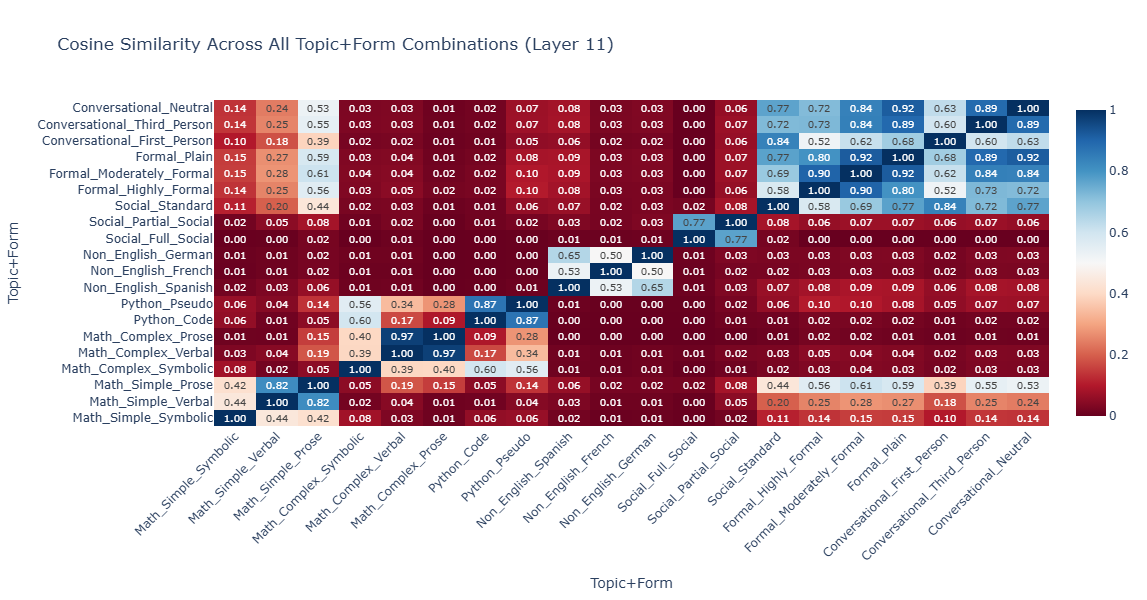


4️⃣ Analyzing clustering patterns...

   Within-topic similarity (same topic, different forms):
      Mean: 0.610
      Pairs: 19

   Cross-topic similarity (different topics):
      Mean: 0.137
      Pairs: 171

   Within-form similarity (same form, different topics):
      Mean: 0.090
      Pairs: 3

   Statistical comparison (within-topic vs cross-topic):
      t-statistic: 8.391
      p-value: 1.1365e-14

5️⃣ Creating scatter plot (PCA projection)...

   PCA variance explained: 30.3%, 17.5%


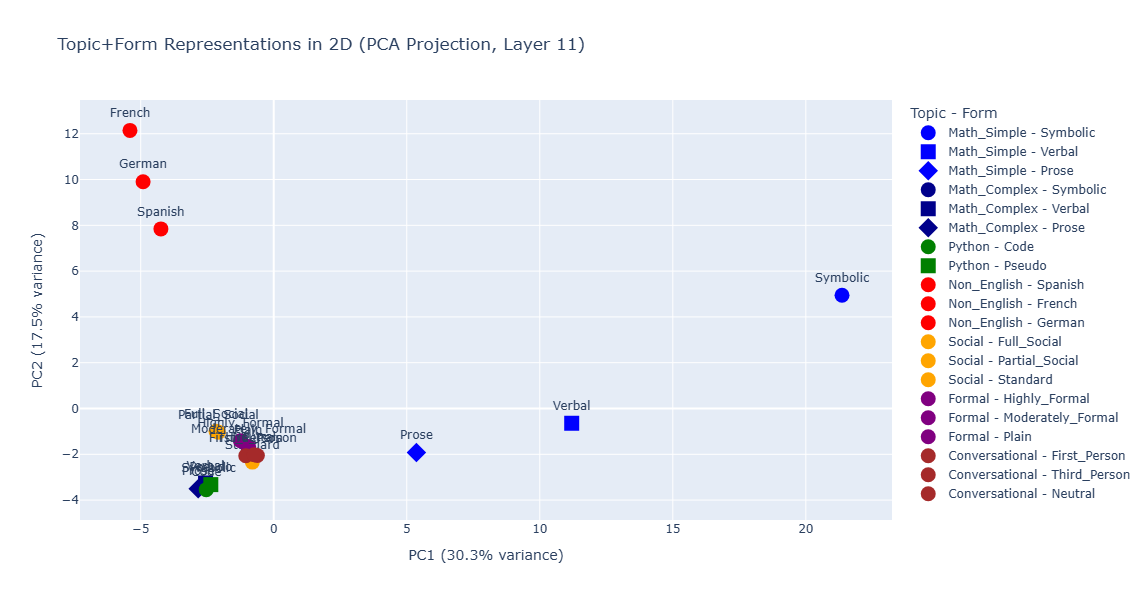


📋 ANALYSIS 3 SUMMARY

   Within-topic similarity: 0.610
   Cross-topic similarity:  0.137
   Difference: 0.472

   → Representations cluster by TOPIC
   → Different forms of the same topic are more similar than different topics



In [15]:
# ============================================================================
# CELL 23: Representational Geometry - Cosine Similarity Analysis
# ============================================================================
print("\n" + "=" * 70)
print("🔬 ANALYSIS 3: REPRESENTATIONAL GEOMETRY (COSINE SIMILARITY)")
print("=" * 70)
print("""
Compute cosine similarity between activation vectors for ALL topic+form
combinations. Do representations cluster by TOPIC or by FORM?
""")

# -----------------------------------------------------------------------------
# Step 1: Compute mean activation vectors for each topic+form
# -----------------------------------------------------------------------------
print("1️⃣ Computing mean activation vectors...\n")

analysis_layer = '11-res-jb'
sae_obj = loaded_saes[analysis_layer]['sae']
hook_point = loaded_saes[analysis_layer]['config']['hook_point']

mean_vectors = {}

for target_key, config in form_analysis_configs.items():
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    mean_vec = features.mean(dim=0).detach().numpy()
    
    mean_vectors[target_key] = {
        'vector': mean_vec,
        'topic': config['topic'],
        'form': config['form']
    }
    
    print(f"   {target_key}: vector computed (dim={len(mean_vec)})")

# -----------------------------------------------------------------------------
# Step 2: Compute pairwise cosine similarity
# -----------------------------------------------------------------------------
print("\n2️⃣ Computing pairwise cosine similarities...\n")

from scipy.spatial.distance import cosine

keys = list(mean_vectors.keys())
n = len(keys)

similarity_matrix = np.zeros((n, n))

for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        vec1 = mean_vectors[key1]['vector']
        vec2 = mean_vectors[key2]['vector']
        
        # Cosine similarity = 1 - cosine distance
        similarity_matrix[i, j] = 1 - cosine(vec1, vec2)

print(f"   Computed {n}x{n} similarity matrix")

# -----------------------------------------------------------------------------
# Step 3: Display similarity matrix
# -----------------------------------------------------------------------------
print("\n3️⃣ Displaying similarity matrix...\n")

# Create labels with topic and form info
labels = [f"{mean_vectors[k]['topic']}_{mean_vectors[k]['form']}" for k in keys]

fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix,
    x=labels,
    y=labels,
    colorscale='RdBu',
    zmid=0.5,
    text=[[f"{v:.2f}" for v in row] for row in similarity_matrix],
    texttemplate="%{text}",
    textfont={"size": 10},
))

fig.update_layout(
    title=f'Cosine Similarity Across All Topic+Form Combinations (Layer 11)',
    xaxis_title='Topic+Form',
    yaxis_title='Topic+Form',
    height=600,
    width=800,
    xaxis_tickangle=-45
)
fig.show()

# -----------------------------------------------------------------------------
# Step 4: Analyze clustering - by topic or by form?
# -----------------------------------------------------------------------------
print("\n4️⃣ Analyzing clustering patterns...\n")

# Within-topic similarity (same topic, different forms)
within_topic_sims = []
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i < j and mean_vectors[key1]['topic'] == mean_vectors[key2]['topic']:
            within_topic_sims.append(similarity_matrix[i, j])

# Cross-topic similarity (different topics)
cross_topic_sims = []
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i < j and mean_vectors[key1]['topic'] != mean_vectors[key2]['topic']:
            cross_topic_sims.append(similarity_matrix[i, j])

# Within-form similarity (same form type across topics)
# Map forms to canonical types
form_mapping = {
    'Symbolic': 'symbolic', 'Verbal': 'verbal', 'Prose': 'prose',
    'Code': 'code', 'Pseudo': 'pseudo'
}

within_form_sims = []
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i < j:
            form1 = mean_vectors[key1]['form']
            form2 = mean_vectors[key2]['form']
            # Check if forms are "similar" (both symbolic-like or both verbal-like)
            if form1 == form2:
                within_form_sims.append(similarity_matrix[i, j])

print(f"   Within-topic similarity (same topic, different forms):")
print(f"      Mean: {np.mean(within_topic_sims):.3f}")
print(f"      Pairs: {len(within_topic_sims)}")

print(f"\n   Cross-topic similarity (different topics):")
print(f"      Mean: {np.mean(cross_topic_sims):.3f}")
print(f"      Pairs: {len(cross_topic_sims)}")

if within_form_sims:
    print(f"\n   Within-form similarity (same form, different topics):")
    print(f"      Mean: {np.mean(within_form_sims):.3f}")
    print(f"      Pairs: {len(within_form_sims)}")

# Statistical test
from scipy import stats

if len(within_topic_sims) > 1 and len(cross_topic_sims) > 1:
    t_stat, p_value = stats.ttest_ind(within_topic_sims, cross_topic_sims)
    print(f"\n   Statistical comparison (within-topic vs cross-topic):")
    print(f"      t-statistic: {t_stat:.3f}")
    print(f"      p-value: {p_value:.4e}")

# -----------------------------------------------------------------------------
# Step 5: Scatter plot via dimensionality reduction
# -----------------------------------------------------------------------------
print("\n5️⃣ Creating scatter plot (PCA projection)...\n")

from sklearn.decomposition import PCA

# Stack all vectors
vector_matrix = np.array([mean_vectors[k]['vector'] for k in keys])

# PCA to 2D
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(vector_matrix)

print(f"   PCA variance explained: {pca.explained_variance_ratio_[0]:.1%}, {pca.explained_variance_ratio_[1]:.1%}")

# Create scatter plot
topics = [mean_vectors[k]['topic'] for k in keys]
forms = [mean_vectors[k]['form'] for k in keys]

# Color by topic, shape by form
topic_colors = {
    'Math_Simple': 'blue', 
    'Math_Complex': 'darkblue', 
    'Python': 'green',
    'Non_English': 'red',
    'Social': 'orange',
    'Formal': 'purple',
    'Conversational': 'brown'
}
form_symbols = {'Symbolic': 'circle', 'Verbal': 'square', 'Prose': 'diamond', 
                'Code': 'circle', 'Pseudo': 'square'}

fig = go.Figure()

for topic in all_topics.keys():
    for form in all_topics[topic].keys():
        key = f"{topic}_{form}"
        if key in keys:
            idx = keys.index(key)
            fig.add_trace(go.Scatter(
                x=[coords_2d[idx, 0]],
                y=[coords_2d[idx, 1]],
                mode='markers+text',
                marker=dict(
                    size=15,
                    color=topic_colors.get(topic, 'gray'),
                    symbol=form_symbols.get(form, 'circle')
                ),
                text=[f"{form}"],
                textposition='top center',
                name=f"{topic} - {form}",
                showlegend=True
            ))

fig.update_layout(
    title='Topic+Form Representations in 2D (PCA Projection, Layer 11)',
    xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
    yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
    height=600,
    width=800,
    legend_title='Topic - Form'
)
fig.show()

# -----------------------------------------------------------------------------
# Step 6: Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 ANALYSIS 3 SUMMARY")
print("=" * 70)

within_mean = np.mean(within_topic_sims)
cross_mean = np.mean(cross_topic_sims)

print(f"\n   Within-topic similarity: {within_mean:.3f}")
print(f"   Cross-topic similarity:  {cross_mean:.3f}")
print(f"   Difference: {within_mean - cross_mean:.3f}")

if within_mean > cross_mean + 0.05:
    print(f"\n   → Representations cluster by TOPIC")
    print(f"   → Different forms of the same topic are more similar than different topics")
elif cross_mean > within_mean + 0.05:
    print(f"\n   → Representations cluster by FORM (unexpected)")
else:
    print(f"\n   → No clear clustering pattern")

print("\n" + "=" * 70)

In [16]:
# ============================================================================
# CELL 24: SYNTHESIS - Summary of Methodological Analysis
# ============================================================================
print("\n" + "=" * 70)
print("📊 SYNTHESIS: METHODOLOGICAL ANALYSIS SUMMARY")
print("=" * 70)
print("""
This analysis tested whether the original Phase 1 specialist identification
was confounded by surface form. We compared:

1. Form-specific specialists (Cell 20): Each topic+form vs all other topics
2. Phase 1 specialists: Original mixed-form baselines vs reference categories

Key question: Are specialists form-invariant or form-specific?
""")

# -----------------------------------------------------------------------------
# Step 1: Map topics to Phase 1 categories
# -----------------------------------------------------------------------------

topic_to_phase1 = {
    'Math_Simple': 'Math',
    'Math_Complex': 'Math',
    'Python': 'Python',
    'Non_English': 'Non-English',
    'Social': 'Social',
    'Formal': 'Formal',
    'Conversational': 'Conversational'
}

# Get Phase 1 specialists for all categories
phase1_specialists = {}
phase1_categories = ['Math', 'Python', 'Non-English', 'Social', 'Formal', 'Conversational']

for cat in phase1_categories:
    phase1_specialists[cat] = {}
    for sae_name in loaded_saes:
        spec = results['specialists'][sae_name].get(cat, {})
        phase1_specialists[cat][sae_name] = spec.get('feature_idx') if spec else None

# -----------------------------------------------------------------------------
# Step 2: Summary of form-specific specialists (from Cell 20)
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("1️⃣ FORM-SPECIFIC SPECIALISTS (Layer 11)")
print("=" * 70)

for topic in all_topics.keys():
    print(f"\n{topic}:")
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    features = []
    for tf in topic_forms:
        feat = form_specific_specialists[tf]['11-res-jb']['feature_idx']
        form = form_specific_specialists[tf]['11-res-jb']['form']
        features.append(feat)
        print(f"   {form}: #{feat}")
    
    unique_features = set(f for f in features if f is not None)
    if len(unique_features) == 1:
        print(f"   → ✅ All forms identify SAME specialist")
    elif len(unique_features) == 0:
        print(f"   → ⚠️ No specialists identified")
    else:
        print(f"   → ❌ Different forms identify DIFFERENT specialists ({len(unique_features)} unique)")

# -----------------------------------------------------------------------------
# Step 3: Comparison to Phase 1 specialists
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("2️⃣ COMPARISON TO PHASE 1 SPECIALISTS (Layer 11)")
print("=" * 70)

print("\nPhase 1 specialists:")
for cat in phase1_categories:
    feat = phase1_specialists[cat]['11-res-jb']
    print(f"   {cat}: #{feat}")

print("\n" + "-" * 70)
print("Which form-specific specialists match Phase 1?")
print("-" * 70)

comparison_results = {}

for topic in all_topics.keys():
    phase1_cat = topic_to_phase1[topic]
    phase1_feat = phase1_specialists[phase1_cat]['11-res-jb']
    
    print(f"\n{topic} (Phase 1 category: {phase1_cat}, feature #{phase1_feat}):")
    
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    matches = []
    
    for tf in topic_forms:
        feat = form_specific_specialists[tf]['11-res-jb']['feature_idx']
        form = form_specific_specialists[tf]['11-res-jb']['form']
        match = "✅ Match" if feat == phase1_feat else "❌ Different"
        print(f"   {form}: #{feat} {match}")
        
        if feat == phase1_feat:
            matches.append(form)
    
    comparison_results[topic] = {
        'phase1_cat': phase1_cat,
        'phase1_feat': phase1_feat,
        'matches': matches,
        'total_forms': len(topic_forms)
    }

# -----------------------------------------------------------------------------
# Step 4: Summary table
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 SUMMARY TABLE")
print("=" * 70)

summary_rows = []
for topic, result in comparison_results.items():
    n_matches = len(result['matches'])
    n_forms = result['total_forms']
    
    if n_matches == n_forms:
        status = "✅ All forms match"
    elif n_matches > 0:
        status = f"⚠️ {n_matches}/{n_forms} forms match"
    else:
        status = "❌ No forms match"
    
    summary_rows.append({
        'Topic': topic,
        'Phase 1 Category': result['phase1_cat'],
        'Phase 1 Feature': result['phase1_feat'],
        'Matching Forms': ', '.join(result['matches']) if result['matches'] else 'None',
        'Status': status
    })

df_summary = pd.DataFrame(summary_rows)
display(df_summary)

# -----------------------------------------------------------------------------
# Step 5: Implications
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 IMPLICATIONS FOR ORIGINAL FINDINGS")
print("=" * 70)

# Categorize topics by match pattern
all_match = []
partial_match = []
no_match = []

for topic, result in comparison_results.items():
    n_matches = len(result['matches'])
    n_forms = result['total_forms']
    
    if n_matches == n_forms:
        all_match.append(topic)
    elif n_matches > 0:
        partial_match.append((topic, result['matches']))
    else:
        no_match.append(topic)

if all_match:
    print(f"\n✅ FORM-INVARIANT TOPICS (all forms match Phase 1):")
    for topic in all_match:
        print(f"   • {topic}")
    print("   → These specialists genuinely detect the topic regardless of surface form")

if partial_match:
    print(f"\n⚠️ PARTIALLY FORM-SPECIFIC TOPICS (some forms match Phase 1):")
    for topic, matches in partial_match:
        print(f"   • {topic}: only {matches} match(es)")
    print("   → Phase 1 specialist was biased toward specific surface forms")

if no_match:
    print(f"\n❌ FULLY FORM-SPECIFIC TOPICS (no forms match Phase 1):")
    for topic in no_match:
        print(f"   • {topic}")
    print("   → Phase 1 specialist does not match any form-specific specialist")
    print("   → Original baseline may have contained different content than matched pairs")

# Overall conclusion
print("\n" + "=" * 70)
print("🎯 OVERALL CONCLUSION")
print("=" * 70)

total_topics = len(comparison_results)
pct_all_match = len(all_match) / total_topics * 100
pct_partial = len(partial_match) / total_topics * 100
pct_no_match = len(no_match) / total_topics * 100

print(f"""
   Form-invariant:    {len(all_match)}/{total_topics} topics ({pct_all_match:.0f}%)
   Partially biased:  {len(partial_match)}/{total_topics} topics ({pct_partial:.0f}%)
   Fully form-specific or mismatched: {len(no_match)}/{total_topics} topics ({pct_no_match:.0f}%)
""")

if pct_all_match > 50:
    print("   → CONCLUSION: Most Phase 1 specialists are form-invariant.")
    print("   → The original methodology was largely sound.")
elif pct_partial + pct_all_match > 50:
    print("   → CONCLUSION: Phase 1 specialists show mixed form-sensitivity.")
    print("   → Some specialists are biased toward specific surface forms.")
else:
    print("   → CONCLUSION: Phase 1 specialists are largely form-specific or mismatched.")
    print("   → The original methodology was confounded by surface form.")
    print("   → H1 results showing form-based activation differences partly reflect circular reasoning.")

print("\n" + "=" * 70)
print("✅ METHODOLOGICAL ANALYSIS COMPLETE")
print("=" * 70)


📊 SYNTHESIS: METHODOLOGICAL ANALYSIS SUMMARY

This analysis tested whether the original Phase 1 specialist identification
was confounded by surface form. We compared:

1. Form-specific specialists (Cell 20): Each topic+form vs all other topics
2. Phase 1 specialists: Original mixed-form baselines vs reference categories

Key question: Are specialists form-invariant or form-specific?


1️⃣ FORM-SPECIFIC SPECIALISTS (Layer 11)

Math_Simple:
   Symbolic: #7029
   Verbal: #4163
   Prose: #4163
   → ❌ Different forms identify DIFFERENT specialists (2 unique)

Math_Complex:
   Symbolic: #22917
   Verbal: #9359
   Prose: #9359
   → ❌ Different forms identify DIFFERENT specialists (2 unique)

Python:
   Code: #3563
   Pseudo: #19151
   → ❌ Different forms identify DIFFERENT specialists (2 unique)

Non_English:
   Spanish: #5861
   French: #5861
   German: #5861
   → ✅ All forms identify SAME specialist

Social:
   Full_Social: #20258
   Partial_Social: #11372
   Standard: #17239
   → ❌ Differ

,Topic,Phase 1 Category,Phase 1 Feature,Matching Forms,Status
0,Math_Simple,Math,22917,None,❌ No forms match
1,Math_Complex,Math,22917,Symbolic,⚠️ 1/3 forms match
2,Python,Python,15983,None,❌ No forms match
3,Non_English,Non-English,4826,None,❌ No forms match
4,Social,Social,20258,Full_Social,⚠️ 1/3 forms match
5,Formal,Formal,17931,None,❌ No forms match
6,Conversational,Conversational,19786,First_Person,⚠️ 1/3 forms match



📋 IMPLICATIONS FOR ORIGINAL FINDINGS

⚠️ PARTIALLY FORM-SPECIFIC TOPICS (some forms match Phase 1):
   • Math_Complex: only ['Symbolic'] match(es)
   • Social: only ['Full_Social'] match(es)
   • Conversational: only ['First_Person'] match(es)
   → Phase 1 specialist was biased toward specific surface forms

❌ FULLY FORM-SPECIFIC TOPICS (no forms match Phase 1):
   • Math_Simple
   • Python
   • Non_English
   • Formal
   → Phase 1 specialist does not match any form-specific specialist
   → Original baseline may have contained different content than matched pairs

🎯 OVERALL CONCLUSION

   Form-invariant:    0/7 topics (0%)
   Partially biased:  3/7 topics (43%)
   Fully form-specific or mismatched: 4/7 topics (57%)

   → CONCLUSION: Phase 1 specialists are largely form-specific or mismatched.
   → The original methodology was confounded by surface form.
   → H1 results showing form-based activation differences partly reflect circular reasoning.

✅ METHODOLOGICAL ANALYSIS COMPLETE
